<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Cube Build with MIRISIM Data

<span style="color:red"> **Instruments Affected**</span>: MIRI

Tested with simulated MIRI MRS data.

#### Author: Isha Nayak

This notebook is the second one that tests the cube build step of Spec3 of the JWST pipeline. The first notebook (https://github.com/spacetelescope/jwst_validation_notebooks/blob/master/jwst_validation_notebooks/cube_build/jwst_cube_build_miri_test/testing_point_source_flux_conservation_modeshep_all.ipynb) looks at data that bypasses MIRISim.

In this notebook we use MIRISim data created with a 4 point dither and SLOW mode to see if a flat source with flux of 0.01 Jy is still flat after being processed by Detector 1, Spec 2, and Spec 3 steps of the pipeline. We skip outlier detection so there are outliers that do not get flagged, resulting in noise spikes in the spectrum. 

In the Detector 1 step we turn off reference pixels because reference pixels are not accounted for in a consistent manner. In the Spec 2 step we turn off straylight because it can sometimes cause problems, and we skip extract 1D and cube build and rely on Spec 3 for those steps instead. In Spec 3 we turn off master background because it does not work well for point sources and the extract 1D step does background subtraction, we turn off mrs imatch because it takes too much computational time, and we turn off outlier detection since that will be a separate notebook that tests the functionality of noise spikes and cosmic rays getting detected.

In the first cube build notebook we inject a point source onto the MRS detector. We find that if we input a flat point source of 0.01 Jy, the standalone cube build function in Spec 3 will output a flat point source of 0.01 Jy within 2%. In each channel the spectrum is flat, but there is a mismatch of up to 2% within bands: i.e. the spectra is flat in Channel 1A and is flat is Channel 1B, but there is a small offset between Channel 1A and 1B. 

In this notebook the critera for passing in Channel/Band 1A through 3C is the median value in those channels has to be within 20% of the input flux of 0.01 Jy. Flux conservations is not perfect with mirisim data and the pipeline adds factors/corrections that cannot actually be tested until we get real data. Therefore the passing criteria in Channel/Band 1A through 3C is that the flux has to be conserved within 20% when using mirisim data and processing it through the pipeline, which is different from the 2% flux conservation criteria when we can bypass mirisim and test cube build.

The critera for passing in 4A through 4C is the median value has to be within 160%. Channel 4 flux calibration is incorrect in mirisim and channel 4 data processes through the pipeline is also incorrect.

#### Update CRDS Context

In [1]:
#Update the context
%env CRDS_CONTEXT=jwst_0719.pmap

env: CRDS_CONTEXT=jwst_0719.pmap


#### Import necessary packages

In [2]:
# Box download imports
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

In [3]:
#JWST functions
import jwst
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

In [4]:
#Mathematics and plotting functions
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
import numpy as np

In [5]:
#Check JWST version
print(jwst.__version__ )

1.3.2


#### Setup Box Files

In [6]:
def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

In [7]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
if use_tempdir:
    data_dir = TemporaryDirectory()
    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    os.chdir(data_dir.name)
# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpjq3fpud1


#### Setup Box Urls

In [8]:
seq1_file_urls = ['https://stsci.box.com/shared/static/bfdwxoi5d1bigpcrm8oax4gs7zvrx7jl.fits',
                 'https://stsci.box.com/shared/static/prkl3tr4tvi19f069kc0mdzfyrq9zqq9.fits',
                 'https://stsci.box.com/shared/static/tt81e5rp4325qn6qjndzr1tygwcd8mi3.fits',
                 'https://stsci.box.com/shared/static/oji8v81g5fvqnz2mplz7vrrxzf09j17i.fits',
                 'https://stsci.box.com/shared/static/qorfegleqsp47wk0c895xl0zzjlsc9za.fits',
                 'https://stsci.box.com/shared/static/55pcsp5867p7a5dg5qx8yazqkuamjwdb.fits']

seq1_file_names = ['det_image_seq1_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq1_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq1_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits']

box_download_list_seq1 = [(url,name) for url,name in zip(seq1_file_urls,seq1_file_names)]

get_box_files(box_download_list_seq1)

In [9]:
seq2_file_urls = ['https://stsci.box.com/shared/static/l0338f4vx7lbt6nacmu5e3qn0t63f0hg.fits',
                 'https://stsci.box.com/shared/static/zbeijqyendw0q3du7ttks4s3a88wulng.fits',
                 'https://stsci.box.com/shared/static/426lhx21n77hyaur9zzi8fclqj6brlnq.fits',
                 'https://stsci.box.com/shared/static/3h2dbj7xrmz0sqtqurmxqzoys48ccguf.fits',
                 'https://stsci.box.com/shared/static/954nenk3p81wes4uo0izvydmuq23pswi.fits',
                 'https://stsci.box.com/shared/static/b20bea8ymgk6gp4bj7i307dgwgyp6bj8.fits']

seq2_file_names = ['det_image_seq2_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq2_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq2_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits']

box_download_list_seq2 = [(url,name) for url,name in zip(seq2_file_urls,seq2_file_names)]

get_box_files(box_download_list_seq2)

In [10]:
seq3_file_urls = ['https://stsci.box.com/shared/static/jtaxk9nka3eiln5s583csvoujvkoim0h.fits',
                 'https://stsci.box.com/shared/static/mqvcswxmdermtj2keu979p35u9f4yten.fits',
                 'https://stsci.box.com/shared/static/nrxoryzu2vy264w5pr11ejeqktxicl7u.fits',
                 'https://stsci.box.com/shared/static/0zdaj8qxj5a2vovtejj15ba12gq4coio.fits',
                 'https://stsci.box.com/shared/static/x7rquwb5o9ncxsm550etnpig68bhqlxc.fits',
                 'https://stsci.box.com/shared/static/1vr3h1rmy7n7e9jq5rum13g496anqn39.fits']

seq3_file_names = ['det_image_seq3_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq3_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq3_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits']

box_download_list_seq3 = [(url,name) for url,name in zip(seq3_file_urls,seq3_file_names)]

get_box_files(box_download_list_seq3)

In [11]:
seq4_file_urls = ['https://stsci.box.com/shared/static/mj13u4iqlqp8altu47wief0pa4nie05z.fits',
                 'https://stsci.box.com/shared/static/9gca440lueo3yl5qwi4h72w1z4imkw07.fits',
                 'https://stsci.box.com/shared/static/4jp6trj5vcu957v7mgrk3x0xswspjsyp.fits',
                 'https://stsci.box.com/shared/static/o0sxswa1fcykbll7ynqobc6xj7pinr72.fits',
                 'https://stsci.box.com/shared/static/c8udg4depbxoha6m7vbntmq1j2vcqljj.fits',
                 'https://stsci.box.com/shared/static/sgp67c1gotmp4kyc4okzjkxpdxcvv2g8.fits',
                 'https://stsci.box.com/shared/static/csgnwqoos19wt9tkavpb0ml75p2j6m0q.json']

seq4_file_names = ['det_image_seq4_MIRIFULONG_34LONGexp1.fits',
                  'det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits',
                  'det_image_seq4_MIRIFULONG_34SHORTexp1.fits',
                  'det_image_seq4_MIRIFUSHORT_12LONGexp1.fits',
                  'det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits',
                  'det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits',
                  'spec3_updated.json']

box_download_list_seq4 = [(url,name) for url,name in zip(seq4_file_urls,seq4_file_names)]

get_box_files(box_download_list_seq4)

#### Setup Loops

In [12]:
#Band Loop 1
band_loop1 = ['12SHORT', '12MEDIUM', '12LONG']

#Band Loop 1
band_loop2 = ['34SHORT', '34MEDIUM', '34LONG']

#Dither Loop
dit_loop = ['seq1', 'seq2', 'seq3', 'seq4']

#Channels
chan_type1=['ch1-short', 'ch1-medium', 'ch1-long', 'ch2-short', 'ch2-medium', 'ch2-long', 'ch3-short', 'ch3-medium', 'ch3-long', 'ch4-short', 'ch4-medium', 'ch4-long']
chan_type2=['1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c', '4a', '4b', '4c']

#Colors
color_list=['black', 'red', 'blue', 'black', 'red', 'blue', 'black', 'red', 'blue', 'black', 'red', 'blue']

#### Setup Detector 1 File Names

In [13]:
name1 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name1[count] = 'det_image_' + dit_loop[i] + '_MIRIFUSHORT_' + band_loop1[j] + 'exp1.fits'
        count=count+1

name2 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name2[count] = 'det_image_' + dit_loop[i] + '_MIRIFULONG_' + band_loop2[j] + 'exp1.fits'
        count=count+1
        
name_det1=np.concatenate((name1,name2))

#### Run Detector 1 and Skip Reference Pixel

In [14]:
for i in range(0,24):
    result_det1 = Detector1Pipeline.call(name_det1[i], save_results = True, steps = {"refpix" : {"skip" : True}})

2021-10-29 21:38:45,716 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:38:45,738 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:38:45,740 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:38:45,742 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:38:45,743 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:38:45,745 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:38:45,747 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:38:45,749 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:38:45,751 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:38:45,753 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:38:45,754 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:38:45,756 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:38:45,758 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:38:45,759 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:38:45,761 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:38:45,762 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:38:45,764 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:38:45,765 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:38:45,897 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits',).


2021-10-29 21:38:45,907 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:38:46,199 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:38:46,266 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:38:46,270 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:38:46,274 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:38:46,277 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:38:46,280 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:38:46,281 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:38:46,286 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:38:46,287 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:38:46,291 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:38:46,296 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:38:46,296 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:38:46,297 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:38:46,299 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:38:46,733 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:46,735 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:47,170 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:38:47,172 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:38:47,173 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:38:47,261 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:47,263 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:47,281 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:38:47,973 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:38:48,104 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:48,106 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:48,129 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:38:49,310 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:38:49,362 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:38:49,368 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:38:49,505 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:49,507 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:49,508 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:38:49,510 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:38:49,592 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:49,594 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:50,079 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:38:50,214 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:50,216 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:50,691 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:38:50,823 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:50,825 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:50,844 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:38:50,845 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:38:50,846 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:38:51,304 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:38:51,440 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:51,442 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:38:51,464 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:38:53,338 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:38:53,472 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:53,474 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:38:53,496 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:38:54,025 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:38:54,157 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:38:54,160 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:38:54,180 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:39:10,595 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:39:10,596 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:39:11,154 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:39:11,398 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:39:11,400 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:39:11,401 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:39:11,403 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:39:11,578 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:39:11,579 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:39:11,589 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:39:11,603 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:39:11,740 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:39:11,847 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:39:12,269 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:39:13,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:39:13,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39301 pixels with at least one CR and at least four groups


2021-10-29 21:39:13,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:39:13,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:39:14,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:39:15,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31156 pixels with at least one CR and at least four groups


2021-10-29 21:39:15,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:39:15,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:39:16,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:39:16,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30071 pixels with at least one CR and at least four groups


2021-10-29 21:39:16,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:39:16,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:39:17,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:39:18,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30705 pixels with at least one CR and at least four groups


2021-10-29 21:39:18,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:39:18,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:39:19,119 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.8485 sec


2021-10-29 21:39:19,123 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.534085


2021-10-29 21:39:19,127 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:39:19,347 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:39:19,349 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:39:19,382 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:39:19,400 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:39:19,418 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:39:19,419 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:39:19,442 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:39:19,444 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:39:58,578 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:39:58,582 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:39:58,758 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:39:58,942 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:39:58,945 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:39:59,002 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:39:59,003 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:39:59,006 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:39:59,096 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:39:59,098 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:39:59,139 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:39:59,140 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:39:59,143 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:39:59,319 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1_rateints.fits


2021-10-29 21:39:59,322 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:39:59,393 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits


2021-10-29 21:39:59,395 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:39:59,821 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:39:59,843 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:39:59,844 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:39:59,846 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:39:59,848 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:39:59,849 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:39:59,851 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:39:59,853 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:39:59,855 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:39:59,857 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:39:59,858 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:39:59,860 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:39:59,861 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:39:59,863 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:39:59,865 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:39:59,866 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:39:59,868 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:39:59,870 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:39:59,965 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:40:00,049 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits',).


2021-10-29 21:40:00,059 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:40:00,309 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:40:00,323 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:40:00,327 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:40:00,329 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:40:00,333 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:40:00,338 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:40:00,339 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:40:00,343 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:40:00,344 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:40:00,348 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:40:00,351 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:40:00,352 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:40:00,354 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:40:00,355 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:40:00,757 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:00,760 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:01,170 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:40:01,172 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:40:01,174 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:40:01,282 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:01,284 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:01,311 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:40:01,841 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:40:01,969 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:01,971 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:01,990 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:40:02,778 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:40:02,828 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:40:02,833 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:40:02,965 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:02,968 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:02,969 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:40:02,972 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:40:03,143 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:03,145 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:03,501 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:40:03,714 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:03,716 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:03,992 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:40:04,202 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:04,204 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:04,223 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:40:04,224 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:40:04,224 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:40:04,523 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:40:04,727 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:04,729 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:04,752 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:40:05,548 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:40:05,780 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:05,782 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:40:05,802 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:40:06,171 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:40:06,378 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:06,380 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:40:06,400 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:40:06,847 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:40:06,850 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:40:07,420 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:40:07,740 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:07,742 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:40:07,743 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:40:07,744 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:40:07,895 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:07,897 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:40:07,906 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:40:07,919 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:40:07,946 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:40:07,966 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:40:08,478 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:40:09,337 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:40:09,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38935 pixels with at least one CR and at least four groups


2021-10-29 21:40:09,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:40:09,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:40:11,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:40:11,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30240 pixels with at least one CR and at least four groups


2021-10-29 21:40:11,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:40:11,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:40:12,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:40:13,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30529 pixels with at least one CR and at least four groups


2021-10-29 21:40:13,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:40:13,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:40:13,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:40:14,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30564 pixels with at least one CR and at least four groups


2021-10-29 21:40:14,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:40:14,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:40:15,417 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.93693 sec


2021-10-29 21:40:15,422 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.515499


2021-10-29 21:40:15,426 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:40:15,651 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:15,653 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:40:15,682 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:40:15,699 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:40:15,717 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:40:15,718 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:40:15,741 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:40:15,743 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:40:50,749 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:40:50,752 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:40:50,914 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:40:51,144 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:51,146 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:51,187 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:40:51,189 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:40:51,192 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:40:51,354 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:51,356 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:51,392 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:40:51,394 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:40:51,397 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:40:51,544 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1_rateints.fits


2021-10-29 21:40:51,546 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:40:51,613 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits


2021-10-29 21:40:51,615 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:40:52,046 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:40:52,076 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:40:52,078 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:40:52,080 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:40:52,081 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:40:52,083 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:40:52,084 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:40:52,086 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:40:52,087 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:40:52,089 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:40:52,090 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:40:52,091 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:40:52,093 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:40:52,094 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:40:52,095 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:40:52,097 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:40:52,100 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:40:52,102 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:40:52,273 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:40:52,350 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits',).


2021-10-29 21:40:52,361 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:40:52,633 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:40:52,645 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:40:52,648 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:40:52,651 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:40:52,654 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:40:52,657 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:40:52,658 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:40:52,661 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:40:52,662 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:40:52,664 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:40:52,667 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:40:52,668 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:40:52,669 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:40:52,670 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:40:53,169 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:53,171 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:53,563 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:40:53,564 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:40:53,566 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:40:53,750 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:53,752 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:53,771 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:40:54,260 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:40:54,469 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:54,472 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:54,491 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:40:55,305 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:40:55,358 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:40:55,365 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:40:55,583 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:55,585 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:55,586 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:40:55,588 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:40:55,755 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:55,757 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:56,206 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:40:56,416 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:56,419 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:56,841 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:40:57,052 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:57,054 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:57,074 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:40:57,075 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:40:57,076 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:40:57,576 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:40:57,788 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:57,791 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:40:57,816 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:40:58,900 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:40:59,118 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:59,121 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:40:59,152 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:40:59,645 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:40:59,859 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:40:59,861 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:40:59,884 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:41:00,436 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:41:00,437 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:41:01,184 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:41:01,471 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:01,473 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:41:01,474 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:41:01,476 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:41:01,648 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:01,650 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:41:01,660 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:41:01,673 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:41:01,701 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:41:01,725 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:41:02,296 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:41:03,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:41:04,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38723 pixels with at least one CR and at least four groups


2021-10-29 21:41:04,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:41:04,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:41:05,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:41:06,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30769 pixels with at least one CR and at least four groups


2021-10-29 21:41:06,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:41:06,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:41:06,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:41:07,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30579 pixels with at least one CR and at least four groups


2021-10-29 21:41:07,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:41:07,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:41:08,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:41:09,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30219 pixels with at least one CR and at least four groups


2021-10-29 21:41:09,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:41:09,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:41:10,274 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.97594 sec


2021-10-29 21:41:10,277 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.617373


2021-10-29 21:41:10,281 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:41:10,496 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:10,498 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:41:10,532 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:41:10,553 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:41:10,571 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:41:10,572 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:41:10,596 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:41:10,599 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:41:47,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:41:47,649 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:41:47,786 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:41:47,951 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:47,953 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:47,990 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:41:47,991 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:41:47,993 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:41:48,080 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:48,082 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:48,115 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:41:48,116 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:41:48,118 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:41:48,243 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1_rateints.fits


2021-10-29 21:41:48,244 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:41:48,306 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits


2021-10-29 21:41:48,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:41:48,694 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:41:48,711 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:41:48,712 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:41:48,714 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:41:48,715 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:41:48,716 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:41:48,717 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:41:48,719 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:41:48,720 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:41:48,721 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:41:48,722 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:41:48,724 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:41:48,725 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:41:48,726 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:41:48,727 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:41:48,729 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:41:48,730 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:41:48,731 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:41:48,824 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:41:48,877 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits',).


2021-10-29 21:41:48,887 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:41:49,147 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:41:49,158 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:41:49,162 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:41:49,165 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:41:49,167 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:41:49,170 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:41:49,171 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:41:49,174 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:41:49,175 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:41:49,179 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:41:49,186 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:41:49,186 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:41:49,187 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:41:49,188 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:41:49,569 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:49,571 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:49,845 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:41:49,846 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:41:49,847 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:41:49,934 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:49,935 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:49,953 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:41:50,307 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:41:50,419 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:50,421 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:50,440 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:41:51,032 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:41:51,070 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:41:51,075 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:41:51,201 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:51,203 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:51,203 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:41:51,205 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:41:51,286 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:51,288 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:51,644 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:41:51,753 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:51,755 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:52,030 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:41:52,149 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:52,151 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:52,168 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:41:52,169 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:41:52,170 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:41:52,467 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:41:52,578 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:52,579 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:41:52,598 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:41:53,368 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:41:53,497 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:53,500 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:41:53,520 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:41:53,862 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:41:53,977 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:53,979 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:41:53,997 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:41:54,446 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:41:54,447 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:41:54,911 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:41:55,076 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:55,077 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:41:55,078 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:41:55,080 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:41:55,166 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:41:55,168 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:41:55,177 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:41:55,189 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:41:55,220 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:41:55,238 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:41:55,652 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:41:56,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:41:57,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38713 pixels with at least one CR and at least four groups


2021-10-29 21:41:57,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:41:57,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:41:58,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:41:58,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30071 pixels with at least one CR and at least four groups


2021-10-29 21:41:58,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:41:58,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:41:59,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:42:00,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30562 pixels with at least one CR and at least four groups


2021-10-29 21:42:00,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:42:00,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:42:00,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:42:01,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30309 pixels with at least one CR and at least four groups


2021-10-29 21:42:01,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:42:01,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:42:02,350 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.6975 sec


2021-10-29 21:42:02,353 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.176696


2021-10-29 21:42:02,357 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:42:02,477 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:42:02,479 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:42:02,520 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:42:02,538 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:42:02,557 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:42:02,558 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:42:02,580 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:42:02,582 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:42:41,301 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:42:41,302 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:42:41,468 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:42:41,623 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:42:41,626 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:41,667 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:42:41,668 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:42:41,671 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:42:41,777 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).


2021-10-29 21:42:41,778 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:41,811 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:42:41,812 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:42:41,814 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:42:41,958 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1_rateints.fits


2021-10-29 21:42:41,959 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:42:42,020 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits


2021-10-29 21:42:42,021 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:42:42,404 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:42:42,422 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:42:42,424 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:42:42,425 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:42:42,426 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:42:42,428 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:42:42,429 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:42:42,430 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:42:42,432 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:42:42,433 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:42:42,434 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:42:42,435 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:42:42,436 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:42:42,438 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:42:42,439 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:42:42,441 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:42:42,442 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:42:42,443 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:42:42,536 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:42:42,597 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits',).


2021-10-29 21:42:42,611 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:42:42,859 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:42:42,870 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:42:42,873 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:42:42,874 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:42:42,877 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:42:42,879 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:42:42,880 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:42:42,886 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:42:42,886 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:42:42,889 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:42:42,892 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:42:42,893 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:42:42,894 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:42:42,895 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:42:43,275 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:43,277 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:43,573 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:42:43,574 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:42:43,575 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:42:43,670 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:43,673 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:43,701 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:42:44,051 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:42:44,165 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:44,167 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:44,186 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:42:44,814 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:42:44,851 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:42:44,856 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:42:44,971 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:44,973 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:44,974 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:42:44,975 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:42:45,057 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:45,059 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:45,417 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:42:45,530 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:45,532 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:45,810 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:42:45,939 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:45,940 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:45,957 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:42:45,958 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:42:45,959 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:42:46,284 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:42:46,395 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:46,397 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:42:46,415 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:42:47,183 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:42:47,304 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:47,306 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:42:47,326 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:42:47,695 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:42:47,815 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:47,816 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:42:47,835 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:42:48,223 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:42:48,224 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:42:48,694 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:42:48,865 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:48,867 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:42:48,868 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:42:48,869 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:42:48,961 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:48,962 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:42:48,971 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:42:48,982 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:42:49,010 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:42:49,043 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:42:49,459 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:42:50,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:42:50,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38792 pixels with at least one CR and at least four groups


2021-10-29 21:42:50,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:42:50,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:42:51,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:42:52,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30929 pixels with at least one CR and at least four groups


2021-10-29 21:42:52,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:42:52,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:42:53,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:42:53,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30677 pixels with at least one CR and at least four groups


2021-10-29 21:42:53,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:42:53,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:42:54,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:42:55,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30359 pixels with at least one CR and at least four groups


2021-10-29 21:42:55,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:42:55,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:42:56,268 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.80748 sec


2021-10-29 21:42:56,272 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.301229


2021-10-29 21:42:56,276 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:42:56,413 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:42:56,414 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:42:56,444 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:42:56,461 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:42:56,478 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:42:56,479 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:42:56,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:42:56,502 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:43:31,032 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:43:31,034 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:43:31,159 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:43:31,305 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:31,307 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:31,358 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:43:31,359 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:43:31,362 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:43:31,448 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:31,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:31,482 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:43:31,483 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:43:31,486 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:43:31,610 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2021-10-29 21:43:31,611 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:43:31,673 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2021-10-29 21:43:31,674 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:43:32,037 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:43:32,053 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:43:32,055 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:43:32,056 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:43:32,057 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:43:32,059 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:43:32,060 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:43:32,061 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:43:32,062 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:43:32,064 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:43:32,065 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:43:32,066 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:43:32,067 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:43:32,068 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:43:32,070 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:43:32,071 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:43:32,072 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:43:32,074 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:43:32,160 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:43:32,211 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits',).


2021-10-29 21:43:32,220 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:43:32,453 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:43:32,460 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:43:32,463 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:43:32,465 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:43:32,468 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:43:32,470 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:43:32,471 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:43:32,474 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:43:32,475 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:43:32,477 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:43:32,479 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:43:32,480 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:43:32,481 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:43:32,482 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:43:32,842 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:32,844 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:33,114 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:43:33,115 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:43:33,117 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:43:33,204 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:33,205 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:33,224 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:43:33,556 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:43:33,667 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:33,668 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:33,687 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:43:34,260 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:43:34,296 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:43:34,301 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:43:34,413 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:34,414 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:34,415 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:43:34,417 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:43:34,499 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:34,500 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:34,789 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:43:34,898 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:34,900 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:35,174 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:43:35,285 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:35,287 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:35,304 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:43:35,305 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:43:35,306 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:43:35,584 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:43:35,695 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:35,697 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:43:35,716 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:43:36,476 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:43:36,589 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:36,590 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:43:36,611 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:43:36,940 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:43:37,050 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:37,052 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:43:37,070 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:43:37,468 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:43:37,469 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:43:37,965 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:43:38,126 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:38,128 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:43:38,129 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:43:38,130 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:43:38,219 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:38,220 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:43:38,229 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:43:38,240 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:43:38,265 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:43:38,283 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:43:38,694 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:43:39,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:43:40,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38919 pixels with at least one CR and at least four groups


2021-10-29 21:43:40,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:43:40,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:43:41,127 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:43:41,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31317 pixels with at least one CR and at least four groups


2021-10-29 21:43:41,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:43:41,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:43:42,582 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:43:43,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31060 pixels with at least one CR and at least four groups


2021-10-29 21:43:43,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:43:43,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:43:44,027 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:43:44,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31057 pixels with at least one CR and at least four groups


2021-10-29 21:43:44,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:43:44,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:43:45,519 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.82385 sec


2021-10-29 21:43:45,522 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.293027


2021-10-29 21:43:45,525 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:43:45,644 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:43:45,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:43:45,675 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:43:45,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:43:45,708 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:43:45,709 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:43:45,731 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:43:45,733 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:44:20,827 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:44:20,829 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:44:20,968 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:44:21,109 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:21,111 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:21,148 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:44:21,149 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:44:21,151 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:44:21,241 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:21,243 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:21,279 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:44:21,280 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:44:21,283 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:44:21,412 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2021-10-29 21:44:21,414 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:44:21,478 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2021-10-29 21:44:21,479 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:44:21,853 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:44:21,871 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:44:21,873 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:44:21,874 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:44:21,875 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:44:21,876 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:44:21,877 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:44:21,879 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:44:21,880 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:44:21,881 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:44:21,882 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:44:21,883 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:44:21,884 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:44:21,886 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:44:21,887 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:44:21,888 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:44:21,889 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:44:21,890 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:44:21,977 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:44:22,026 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits',).


2021-10-29 21:44:22,036 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:44:22,269 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:44:22,273 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:44:22,276 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:44:22,277 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:44:22,279 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:44:22,281 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:44:22,282 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:44:22,284 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:44:22,285 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:44:22,286 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:44:22,289 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:44:22,290 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:44:22,291 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:44:22,291 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:44:22,630 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:22,632 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:22,899 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:44:22,900 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:44:22,901 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:44:22,988 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:22,989 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:23,007 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:44:23,334 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:44:23,442 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:23,444 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:23,463 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:44:24,028 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:44:24,064 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:44:24,069 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:44:24,178 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:24,179 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:24,180 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:44:24,182 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:44:24,262 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:24,264 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:24,534 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:44:24,649 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:24,651 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:24,924 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:44:25,033 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:25,035 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:25,052 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:44:25,053 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:44:25,053 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:44:25,316 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:44:25,427 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:25,428 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:44:25,447 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:44:26,216 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:44:26,327 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:26,329 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:44:26,349 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:44:26,657 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:44:26,771 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:26,772 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:44:26,791 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:44:27,177 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:44:27,178 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:44:27,706 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:44:27,869 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:27,871 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:44:27,871 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:44:27,873 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:44:27,962 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:27,963 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:44:27,972 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:44:27,984 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:44:28,012 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:44:28,031 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:44:28,414 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:44:29,241 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:44:29,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38738 pixels with at least one CR and at least four groups


2021-10-29 21:44:29,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:44:29,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:44:30,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:44:31,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30400 pixels with at least one CR and at least four groups


2021-10-29 21:44:31,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:44:31,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:44:32,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:44:32,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31241 pixels with at least one CR and at least four groups


2021-10-29 21:44:32,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:44:32,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:44:33,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:44:34,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31142 pixels with at least one CR and at least four groups


2021-10-29 21:44:34,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:44:34,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:44:35,208 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.79255 sec


2021-10-29 21:44:35,211 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.239223


2021-10-29 21:44:35,216 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:44:35,406 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:44:35,409 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:44:35,448 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:44:35,466 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:44:35,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:44:35,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:44:35,509 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:44:35,512 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:45:11,923 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:45:11,924 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:45:12,053 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:45:12,200 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:12,202 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:12,238 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:45:12,239 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:45:12,241 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:45:12,333 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:12,335 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:12,366 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:45:12,367 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:45:12,370 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:45:12,498 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2021-10-29 21:45:12,500 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:45:12,560 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2021-10-29 21:45:12,561 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:45:12,914 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:45:12,930 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:45:12,932 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:45:12,933 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:45:12,934 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:45:12,936 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:45:12,937 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:45:12,938 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:45:12,939 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:45:12,940 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:45:12,942 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:45:12,943 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:45:12,944 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:45:12,945 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:45:12,946 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:45:12,947 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:45:12,949 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:45:12,950 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:45:13,034 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:45:13,100 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits',).


2021-10-29 21:45:13,110 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:45:13,330 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:45:13,334 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:45:13,337 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:45:13,339 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:45:13,344 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:45:13,346 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:45:13,347 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:45:13,349 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:45:13,350 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:45:13,354 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:45:13,357 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:45:13,358 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:45:13,359 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:45:13,360 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:45:13,708 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:13,710 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:13,978 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:45:13,979 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:45:13,980 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:45:14,064 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:14,066 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:14,084 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:45:14,424 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:45:14,532 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:14,534 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:14,552 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:45:15,114 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:45:15,151 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:45:15,156 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:45:15,274 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:15,276 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:15,277 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:45:15,278 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:45:15,359 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:15,360 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:15,660 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:45:15,767 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:15,769 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:16,039 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:45:16,151 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:16,153 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:16,170 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:45:16,171 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:45:16,171 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:45:16,462 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:45:16,570 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:16,572 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:45:16,589 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:45:17,333 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:45:17,447 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:17,449 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:45:17,468 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:45:17,810 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:45:17,921 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:17,923 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:45:17,941 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:45:18,332 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:45:18,333 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:45:18,851 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:45:19,011 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:19,013 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:45:19,013 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:45:19,015 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:45:19,105 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:19,107 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:45:19,115 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:45:19,126 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:45:19,152 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:45:19,169 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:45:19,579 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:45:20,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:45:20,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38655 pixels with at least one CR and at least four groups


2021-10-29 21:45:20,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:45:20,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:45:21,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:45:22,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 29945 pixels with at least one CR and at least four groups


2021-10-29 21:45:22,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:45:22,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:45:23,408 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:45:23,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30672 pixels with at least one CR and at least four groups


2021-10-29 21:45:23,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:45:23,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:45:24,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:45:25,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30051 pixels with at least one CR and at least four groups


2021-10-29 21:45:25,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:45:25,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:45:26,229 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.64857 sec


2021-10-29 21:45:26,232 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.116359


2021-10-29 21:45:26,235 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:45:26,345 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:45:26,347 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:45:26,376 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:45:26,393 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:45:26,411 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:45:26,412 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:45:26,433 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:45:26,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:46:00,694 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:46:00,696 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:46:00,826 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:46:00,952 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:46:00,954 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:00,994 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:46:00,994 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:46:00,997 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:46:01,084 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1.fits>,).


2021-10-29 21:46:01,086 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:01,123 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:46:01,123 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:46:01,126 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:46:01,259 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rateints.fits


2021-10-29 21:46:01,261 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:46:01,323 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits


2021-10-29 21:46:01,324 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:46:01,718 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:46:01,735 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:46:01,736 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:46:01,737 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:46:01,738 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:46:01,739 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:46:01,740 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:46:01,742 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:46:01,743 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:46:01,744 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:46:01,745 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:46:01,746 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:46:01,747 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:46:01,748 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:46:01,749 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:46:01,750 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:46:01,751 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:46:01,752 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:46:01,843 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFUSHORT_12LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:46:01,900 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12LONGexp1.fits',).


2021-10-29 21:46:01,910 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:46:02,142 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:46:02,146 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:46:02,148 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:46:02,150 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:46:02,152 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:46:02,154 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:46:02,155 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:46:02,158 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:46:02,159 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:46:02,161 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:46:02,163 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:46:02,163 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:46:02,164 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:46:02,164 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:46:02,532 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:02,534 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:02,821 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:46:02,822 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:46:02,824 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:46:02,911 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:02,912 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:02,931 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:46:03,280 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:46:03,394 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:03,396 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:03,415 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:46:04,003 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:46:04,040 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:46:04,046 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:46:04,164 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:04,166 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:04,167 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:46:04,168 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:46:04,257 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:04,259 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:04,565 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:46:04,682 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:04,684 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:04,973 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:46:05,088 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:05,090 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:05,107 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:46:05,107 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:46:05,108 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:46:05,402 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:46:05,517 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:05,519 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:05,537 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:46:06,323 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:46:06,440 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:06,442 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:46:06,461 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:46:06,803 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:46:06,921 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:06,923 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:46:06,944 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:46:07,335 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:46:07,336 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:46:07,875 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:46:08,039 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:08,041 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:46:08,042 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:46:08,043 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:46:08,131 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:08,132 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:46:08,141 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:46:08,152 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:46:08,179 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:46:08,197 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:46:08,614 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:46:09,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:46:09,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38941 pixels with at least one CR and at least four groups


2021-10-29 21:46:09,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:46:09,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:46:11,005 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:46:11,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30261 pixels with at least one CR and at least four groups


2021-10-29 21:46:11,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:46:11,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:46:12,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:46:12,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30451 pixels with at least one CR and at least four groups


2021-10-29 21:46:13,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:46:13,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:46:13,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:46:14,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30114 pixels with at least one CR and at least four groups


2021-10-29 21:46:14,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:46:14,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:46:15,300 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.68433 sec


2021-10-29 21:46:15,302 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.161346


2021-10-29 21:46:15,305 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:46:15,421 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:15,422 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:46:15,451 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:46:15,468 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:46:15,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:46:15,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:46:15,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:46:15,508 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:46:49,728 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:46:49,730 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:46:49,861 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:46:50,011 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:50,013 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:50,052 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:46:50,053 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:46:50,056 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:46:50,144 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:50,146 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:50,182 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:46:50,183 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:46:50,185 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:46:50,315 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_rateints.fits


2021-10-29 21:46:50,316 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:46:50,376 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits


2021-10-29 21:46:50,377 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:46:50,738 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:46:50,754 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:46:50,755 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:46:50,757 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:46:50,758 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:46:50,759 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:46:50,760 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:46:50,762 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:46:50,763 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:46:50,764 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:46:50,765 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:46:50,767 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:46:50,768 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:46:50,769 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:46:50,770 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:46:50,772 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:46:50,773 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:46:50,774 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:46:50,858 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFUSHORT_12LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:46:50,914 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12LONGexp1.fits',).


2021-10-29 21:46:50,924 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:46:51,139 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:46:51,143 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:46:51,146 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:46:51,148 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:46:51,151 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:46:51,153 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:46:51,153 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:46:51,155 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:46:51,156 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:46:51,162 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:46:51,164 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:46:51,164 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:46:51,165 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:46:51,166 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:46:51,511 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:51,513 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:51,802 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:46:51,803 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:46:51,805 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:46:51,892 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:51,893 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:51,911 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:46:52,255 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:46:52,371 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:52,373 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:52,391 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:46:52,984 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:46:53,021 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:46:53,026 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:46:53,143 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:53,145 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:53,146 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:46:53,148 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:46:53,232 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:53,234 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:53,538 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:46:53,652 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:53,653 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:53,942 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:46:54,057 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:54,059 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:54,076 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:46:54,077 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:46:54,078 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:46:54,371 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:46:54,485 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:54,487 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:46:54,505 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:46:55,288 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:46:55,481 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:55,483 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:46:55,506 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:46:55,976 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:46:56,181 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:56,184 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:46:56,204 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:46:56,718 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:46:56,719 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:46:57,445 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:46:57,724 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:57,727 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:46:57,728 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:46:57,730 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:46:57,901 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:46:57,903 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:46:57,913 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:46:57,925 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:46:57,954 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:46:57,974 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:46:58,562 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:46:59,693 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:47:00,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39060 pixels with at least one CR and at least four groups


2021-10-29 21:47:00,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:00,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:47:01,497 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:47:02,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30590 pixels with at least one CR and at least four groups


2021-10-29 21:47:02,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:02,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:47:03,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:47:03,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30439 pixels with at least one CR and at least four groups


2021-10-29 21:47:03,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:03,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:47:04,780 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:47:05,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30471 pixels with at least one CR and at least four groups


2021-10-29 21:47:05,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:05,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:47:06,452 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.8885 sec


2021-10-29 21:47:06,456 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.542591


2021-10-29 21:47:06,459 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:47:06,663 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:06,665 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:47:06,706 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:47:06,724 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:47:06,743 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:47:06,745 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:47:06,769 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:47:06,772 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:47:44,103 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:47:44,105 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:47:44,247 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:47:44,419 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:44,421 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:44,458 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:47:44,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:47:44,461 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:47:44,548 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:44,550 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:44,585 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:47:44,586 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:47:44,588 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:47:44,715 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_rateints.fits


2021-10-29 21:47:44,716 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:47:44,779 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits


2021-10-29 21:47:44,780 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:47:45,154 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:47:45,173 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:47:45,175 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:47:45,176 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:47:45,177 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:47:45,179 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:47:45,180 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:47:45,181 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:47:45,182 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:47:45,184 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:47:45,185 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:47:45,186 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:47:45,187 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:47:45,188 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:47:45,189 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:47:45,191 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:47:45,192 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:47:45,193 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:47:45,297 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFUSHORT_12LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:47:45,359 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12LONGexp1.fits',).


2021-10-29 21:47:45,369 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:47:45,632 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:47:45,637 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:47:45,639 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:47:45,640 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:47:45,642 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:47:45,644 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:47:45,645 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:47:45,648 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:47:45,648 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:47:45,650 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:47:45,653 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:47:45,653 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:47:45,654 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:47:45,655 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:47:46,138 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:46,140 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:46,565 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:47:46,567 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:47:46,569 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:47:46,749 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:46,751 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:46,772 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:47:47,265 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:47:47,480 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:47,482 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:47,504 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:47:48,400 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:47:48,450 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:47:48,456 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:47:48,660 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:48,663 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:48,664 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:47:48,666 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:47:48,838 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:48,840 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:49,316 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:47:49,516 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:49,519 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:49,857 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:47:49,993 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:49,995 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:50,012 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:47:50,013 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:47:50,014 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:47:50,366 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:47:50,481 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:50,484 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:47:50,505 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:47:51,304 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:47:51,451 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:51,452 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:47:51,472 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:47:51,884 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:47:52,015 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:52,017 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:47:52,037 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:47:52,485 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:47:52,490 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:47:53,052 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:47:53,237 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:53,239 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:47:53,240 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:47:53,241 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:47:53,328 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:47:53,330 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:47:53,341 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:47:53,352 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:47:53,381 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:47:53,400 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:47:53,811 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:47:54,645 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:47:55,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38669 pixels with at least one CR and at least four groups


2021-10-29 21:47:55,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:55,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:47:56,256 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:47:56,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30263 pixels with at least one CR and at least four groups


2021-10-29 21:47:56,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:56,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:47:57,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:47:58,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30470 pixels with at least one CR and at least four groups


2021-10-29 21:47:58,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:58,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:47:59,153 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:47:59,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31060 pixels with at least one CR and at least four groups


2021-10-29 21:47:59,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:47:59,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:48:00,639 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.82665 sec


2021-10-29 21:48:00,644 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.302887


2021-10-29 21:48:00,648 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:48:00,792 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:00,794 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:48:00,829 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:48:00,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:48:00,865 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:48:00,866 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:48:00,889 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:48:00,891 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:48:35,384 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:48:35,387 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:48:35,517 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:48:35,663 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:35,665 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:35,717 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:48:35,718 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:48:35,721 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:48:35,808 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:35,810 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:35,848 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:48:35,849 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:48:35,852 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:48:35,973 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_rateints.fits


2021-10-29 21:48:35,975 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:48:36,036 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits


2021-10-29 21:48:36,037 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:48:36,405 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:48:36,425 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:48:36,427 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:48:36,429 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:48:36,431 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:48:36,433 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:48:36,434 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:48:36,436 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:48:36,438 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:48:36,439 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:48:36,441 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:48:36,442 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:48:36,444 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:48:36,445 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:48:36,446 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:48:36,448 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:48:36,449 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:48:36,451 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:48:36,542 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFUSHORT_12LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:48:36,605 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12LONGexp1.fits',).


2021-10-29 21:48:36,615 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:48:36,837 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:48:36,841 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits'.


2021-10-29 21:48:36,843 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits'.


2021-10-29 21:48:36,845 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits'.


2021-10-29 21:48:36,848 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits'.


2021-10-29 21:48:36,850 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:48:36,851 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits'.


2021-10-29 21:48:36,854 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:48:36,855 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits'.


2021-10-29 21:48:36,857 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits'.


2021-10-29 21:48:36,859 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:48:36,859 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:48:36,860 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:48:36,861 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:48:37,230 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:37,233 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:37,501 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:48:37,502 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:48:37,504 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:48:37,593 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:37,595 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:37,614 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0022.fits


2021-10-29 21:48:37,965 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:48:38,077 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:38,079 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:38,101 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0025.fits


2021-10-29 21:48:38,754 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-10-29 21:48:38,790 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:48:38,796 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:48:38,914 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:38,916 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:38,917 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:48:38,919 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:48:39,005 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:39,006 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:39,313 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:48:39,424 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:39,426 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:39,699 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:48:39,815 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:39,818 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:39,836 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:48:39,838 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:48:39,839 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:48:40,133 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:48:40,245 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:40,247 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:48:40,266 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0023.fits


2021-10-29 21:48:41,024 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:48:41,142 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:41,144 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:48:41,164 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0012.fits


2021-10-29 21:48:41,499 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:48:41,611 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:41,613 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:48:41,633 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0044.fits


2021-10-29 21:48:42,022 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:48:42,024 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:48:42,525 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:48:42,699 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:42,702 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:48:42,704 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:48:42,706 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:48:42,796 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:42,798 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:48:42,808 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:48:42,819 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:48:42,851 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:48:42,869 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:48:43,286 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:48:44,111 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:48:44,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38732 pixels with at least one CR and at least four groups


2021-10-29 21:48:44,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:48:44,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:48:45,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:48:46,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30156 pixels with at least one CR and at least four groups


2021-10-29 21:48:46,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:48:46,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:48:47,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:48:47,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30763 pixels with at least one CR and at least four groups


2021-10-29 21:48:47,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:48:47,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:48:48,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:48:49,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30870 pixels with at least one CR and at least four groups


2021-10-29 21:48:49,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:48:49,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-10-29 21:48:50,041 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.75336 sec


2021-10-29 21:48:50,044 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.235301


2021-10-29 21:48:50,047 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:48:50,160 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:48:50,162 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:48:50,191 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0050.fits


2021-10-29 21:48:50,209 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0007.fits


2021-10-29 21:48:50,227 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:48:50,228 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:48:50,249 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:48:50,251 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:49:24,881 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:49:24,884 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:49:25,011 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:49:25,158 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:49:25,160 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:25,194 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:49:25,195 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:49:25,198 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:49:25,286 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1.fits>,).


2021-10-29 21:49:25,288 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:25,321 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:49:25,322 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:49:25,326 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:49:25,449 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_rateints.fits


2021-10-29 21:49:25,450 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:49:25,511 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits


2021-10-29 21:49:25,512 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:49:25,891 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:49:25,908 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:49:25,910 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:49:25,912 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:49:25,914 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:49:25,916 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:49:25,917 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:49:25,919 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:49:25,921 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:49:25,922 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:49:25,924 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:49:25,925 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:49:25,928 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:49:25,929 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:49:25,931 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:49:25,933 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:49:25,935 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:49:25,936 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:49:26,027 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFULONG_34SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:49:26,081 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFULONG_34SHORTexp1.fits',).


2021-10-29 21:49:26,091 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:49:26,307 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:49:26,335 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:49:26,338 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:49:26,341 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2021-10-29 21:49:26,345 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:49:26,350 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:49:26,351 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:49:26,357 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:49:26,358 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:49:26,361 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:49:26,363 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:49:26,364 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:49:26,365 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:49:26,367 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:49:26,699 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:26,701 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:26,971 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:49:26,972 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:49:26,974 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:49:27,061 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:27,064 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:27,082 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:49:27,553 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:49:27,666 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:27,668 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:27,688 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:49:29,259 - stpipe.Detector1Pipeline.saturation - INFO - Detected 290 saturated pixels


2021-10-29 21:49:29,296 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:49:29,301 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:49:29,418 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:29,420 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:29,420 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:49:29,422 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:49:29,507 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:29,509 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:29,812 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:49:29,922 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:29,924 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:30,196 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:49:30,311 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:30,313 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:30,330 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:49:30,331 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:49:30,332 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:49:30,625 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:49:30,740 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:30,742 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:49:30,763 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2021-10-29 21:49:36,546 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:49:36,663 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:36,665 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:49:36,691 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:49:37,040 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:49:37,152 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:37,154 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:49:37,175 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:49:52,011 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:49:52,012 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:49:52,720 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:49:52,977 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:52,979 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:49:52,980 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:49:52,982 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:49:53,151 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:49:53,153 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:49:53,163 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:49:53,175 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:49:53,297 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:49:53,458 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:49:54,064 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:49:55,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:49:55,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39182 pixels with at least one CR and at least four groups


2021-10-29 21:49:55,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:49:55,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:49:57,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:49:57,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31858 pixels with at least one CR and at least four groups


2021-10-29 21:49:57,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:49:57,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:49:58,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:49:59,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31243 pixels with at least one CR and at least four groups


2021-10-29 21:49:59,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:49:59,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:50:00,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:50:01,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30779 pixels with at least one CR and at least four groups


2021-10-29 21:50:01,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:50:01,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 45 pixels with at least one CR and two groups


2021-10-29 21:50:02,059 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.9936 sec


2021-10-29 21:50:02,062 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.899453


2021-10-29 21:50:02,065 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:50:02,271 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:02,273 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:50:02,306 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:50:02,323 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:50:02,340 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:50:02,341 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:50:02,365 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:50:02,368 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:50:37,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:50:37,490 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:50:37,628 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:50:37,797 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:37,800 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:37,849 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:50:37,850 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:50:37,853 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:50:37,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:37,942 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:37,976 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:50:37,977 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:50:37,980 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:50:38,122 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34SHORTexp1_rateints.fits


2021-10-29 21:50:38,128 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:50:38,201 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits


2021-10-29 21:50:38,202 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:50:38,596 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:50:38,616 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:50:38,618 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:50:38,620 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:50:38,622 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:50:38,623 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:50:38,625 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:50:38,627 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:50:38,628 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:50:38,630 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:50:38,632 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:50:38,634 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:50:38,635 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:50:38,637 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:50:38,641 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:50:38,644 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:50:38,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:50:38,649 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:50:38,760 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFULONG_34SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:50:38,813 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFULONG_34SHORTexp1.fits',).


2021-10-29 21:50:38,823 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:50:39,041 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:50:39,053 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:50:39,056 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:50:39,058 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2021-10-29 21:50:39,060 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:50:39,063 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:50:39,064 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:50:39,066 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:50:39,068 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:50:39,071 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:50:39,074 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:50:39,075 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:50:39,075 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:50:39,076 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:50:39,411 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:39,413 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:39,719 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:50:39,720 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:50:39,722 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:50:39,818 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:39,819 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:39,838 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:50:40,182 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:50:40,294 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:40,295 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:40,314 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:50:40,889 - stpipe.Detector1Pipeline.saturation - INFO - Detected 285 saturated pixels


2021-10-29 21:50:40,926 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:50:40,931 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:50:41,050 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:41,052 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:41,053 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:50:41,054 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:50:41,142 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:41,145 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:41,460 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:50:41,573 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:41,575 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:41,846 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:50:41,964 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:41,966 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:41,983 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:50:41,984 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:50:41,985 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:50:42,277 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:50:42,388 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:42,390 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:50:42,408 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2021-10-29 21:50:43,219 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:50:43,335 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:43,337 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:50:43,358 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:50:43,692 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:50:43,807 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:43,809 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:50:43,828 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:50:44,270 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:50:44,271 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:50:44,794 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:50:44,964 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:44,966 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:50:44,967 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:50:44,969 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:50:45,060 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:45,061 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:50:45,070 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:50:45,081 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:50:45,111 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:50:45,129 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:50:45,612 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:50:46,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:50:47,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39701 pixels with at least one CR and at least four groups


2021-10-29 21:50:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:50:47,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 45 pixels with at least one CR and two groups


2021-10-29 21:50:48,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:50:48,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31649 pixels with at least one CR and at least four groups


2021-10-29 21:50:48,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:50:48,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 15 pixels with at least one CR and two groups


2021-10-29 21:50:49,589 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:50:50,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31912 pixels with at least one CR and at least four groups


2021-10-29 21:50:50,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:50:50,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 45 pixels with at least one CR and two groups


2021-10-29 21:50:51,100 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:50:51,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31430 pixels with at least one CR and at least four groups


2021-10-29 21:50:51,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:50:51,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-10-29 21:50:52,601 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.98703 sec


2021-10-29 21:50:52,605 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.534907


2021-10-29 21:50:52,609 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:50:52,751 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:50:52,753 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:50:52,786 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:50:52,804 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:50:52,823 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:50:52,824 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:50:52,846 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:50:52,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:51:25,442 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:51:25,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:51:25,574 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:51:25,723 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:25,725 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:25,759 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:51:25,760 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:51:25,763 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:51:25,853 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:25,855 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:25,889 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:51:25,890 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:51:25,893 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:51:26,018 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1_rateints.fits


2021-10-29 21:51:26,020 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:51:26,082 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits


2021-10-29 21:51:26,083 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:51:26,460 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:51:26,476 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:51:26,478 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:51:26,480 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:51:26,481 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:51:26,483 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:51:26,485 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:51:26,486 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:51:26,488 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:51:26,489 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:51:26,491 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:51:26,492 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:51:26,493 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:51:26,495 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:51:26,496 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:51:26,498 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:51:26,499 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:51:26,501 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:51:26,589 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFULONG_34SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:51:26,647 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFULONG_34SHORTexp1.fits',).


2021-10-29 21:51:26,657 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:51:26,892 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:51:26,901 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:51:26,904 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:51:26,906 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2021-10-29 21:51:26,908 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:51:26,910 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:51:26,911 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:51:26,913 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:51:26,914 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:51:26,917 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:51:26,919 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:51:26,920 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:51:26,921 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:51:26,922 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:51:27,282 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:27,284 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:27,612 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:51:27,613 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:51:27,615 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:51:27,707 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:27,709 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:27,728 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:51:28,075 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:51:28,187 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:28,189 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:28,208 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:51:28,780 - stpipe.Detector1Pipeline.saturation - INFO - Detected 275 saturated pixels


2021-10-29 21:51:28,817 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:51:28,822 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:51:28,938 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:28,939 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:28,940 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:51:28,942 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:51:29,027 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:29,029 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:29,333 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:51:29,443 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:29,445 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:29,719 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:51:29,834 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:29,836 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:29,853 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:51:29,855 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:51:29,855 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:51:30,150 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:51:30,261 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:30,262 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:51:30,282 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2021-10-29 21:51:31,038 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:51:31,156 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:31,158 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:51:31,177 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:51:31,518 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:51:31,630 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:31,632 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:51:31,651 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:51:32,042 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:51:32,044 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:51:32,597 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:51:32,763 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:32,765 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:51:32,765 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:51:32,767 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:51:32,858 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:32,860 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:51:32,869 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:51:32,881 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:51:32,910 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:51:32,931 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:51:33,336 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:51:34,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:51:34,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39589 pixels with at least one CR and at least four groups


2021-10-29 21:51:34,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:51:34,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:51:35,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:51:36,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31362 pixels with at least one CR and at least four groups


2021-10-29 21:51:36,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:51:36,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 40 pixels with at least one CR and two groups


2021-10-29 21:51:37,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:51:37,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31035 pixels with at least one CR and at least four groups


2021-10-29 21:51:37,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:51:37,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 45 pixels with at least one CR and two groups


2021-10-29 21:51:38,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:51:39,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31374 pixels with at least one CR and at least four groups


2021-10-29 21:51:39,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:51:39,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 15 pixels with at least one CR and two groups


2021-10-29 21:51:40,105 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.76748 sec


2021-10-29 21:51:40,109 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.239822


2021-10-29 21:51:40,112 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:51:40,244 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:51:40,246 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:51:40,291 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:51:40,309 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:51:40,331 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:51:40,332 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:51:40,356 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:51:40,358 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:52:11,996 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:52:11,998 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:52:12,125 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:52:12,252 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:12,254 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:12,291 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:52:12,292 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:52:12,295 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:52:12,382 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:12,384 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:12,416 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:52:12,417 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:52:12,420 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:52:12,547 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1_rateints.fits


2021-10-29 21:52:12,549 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:52:12,611 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits


2021-10-29 21:52:12,611 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:52:12,983 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:52:13,002 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:52:13,005 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:52:13,006 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:52:13,008 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:52:13,010 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:52:13,012 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:52:13,014 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:52:13,016 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:52:13,017 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:52:13,018 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:52:13,021 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:52:13,022 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:52:13,023 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:52:13,025 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:52:13,027 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:52:13,029 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:52:13,030 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:52:13,122 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFULONG_34SHORTexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:52:13,178 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFULONG_34SHORTexp1.fits',).


2021-10-29 21:52:13,188 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:52:13,402 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:52:13,413 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:52:13,415 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:52:13,417 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits'.


2021-10-29 21:52:13,419 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:52:13,421 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:52:13,423 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:52:13,425 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:52:13,426 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:52:13,428 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:52:13,430 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:52:13,431 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:52:13,432 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:52:13,433 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:52:13,779 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:13,782 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:14,048 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:52:14,049 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:52:14,051 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:52:14,144 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:14,147 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:14,169 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:52:14,509 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:52:14,620 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:14,622 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:14,641 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:52:15,204 - stpipe.Detector1Pipeline.saturation - INFO - Detected 303 saturated pixels


2021-10-29 21:52:15,239 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:52:15,244 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:52:15,360 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:15,362 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:15,363 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:52:15,365 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:52:15,448 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:15,449 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:15,806 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:52:15,918 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:15,920 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:16,188 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:52:16,305 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:16,307 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:16,324 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:52:16,325 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:52:16,326 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:52:16,616 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:52:16,729 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:16,731 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:16,758 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0026.fits


2021-10-29 21:52:17,500 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:52:17,616 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:17,618 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:52:17,640 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:52:17,984 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:52:18,097 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:18,100 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:52:18,120 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:52:18,521 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:52:18,522 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:52:19,018 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:52:19,182 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:19,184 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:52:19,185 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:52:19,187 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:52:19,276 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:19,278 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:52:19,289 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:52:19,302 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:52:19,330 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:52:19,348 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:52:19,758 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:52:20,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:52:21,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 40246 pixels with at least one CR and at least four groups


2021-10-29 21:52:21,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:52:21,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-10-29 21:52:22,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:52:22,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32003 pixels with at least one CR and at least four groups


2021-10-29 21:52:22,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:52:22,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:52:23,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:52:24,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31980 pixels with at least one CR and at least four groups


2021-10-29 21:52:24,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:52:24,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:52:25,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:52:25,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31732 pixels with at least one CR and at least four groups


2021-10-29 21:52:25,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:52:25,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-10-29 21:52:26,714 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.95466 sec


2021-10-29 21:52:26,717 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.428169


2021-10-29 21:52:26,720 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:52:26,840 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:26,842 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:52:26,873 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:52:26,891 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:52:26,910 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:52:26,911 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:52:26,932 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:52:26,934 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:52:59,208 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:52:59,210 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:52:59,336 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:52:59,477 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:59,479 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:59,519 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:52:59,520 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:52:59,523 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:52:59,610 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1.fits>,).


2021-10-29 21:52:59,612 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:52:59,645 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:52:59,646 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:52:59,649 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:52:59,775 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1_rateints.fits


2021-10-29 21:52:59,776 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:52:59,837 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits


2021-10-29 21:52:59,838 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:53:00,227 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:53:00,246 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:53:00,248 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:53:00,249 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:53:00,251 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:53:00,252 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:53:00,254 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:53:00,256 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:53:00,258 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:53:00,259 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:53:00,261 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:53:00,265 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:53:00,267 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:53:00,269 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:53:00,271 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:53:00,273 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:53:00,274 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:53:00,275 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:53:00,364 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:53:00,419 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits',).


2021-10-29 21:53:00,429 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:53:00,660 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:53:00,667 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:53:00,669 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:53:00,670 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2021-10-29 21:53:00,673 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:53:00,674 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:53:00,675 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:53:00,677 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:53:00,677 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:53:00,679 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:53:00,681 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:53:00,681 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:53:00,682 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:53:00,683 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:53:01,032 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:01,034 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:01,389 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:53:01,390 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:53:01,392 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:53:01,484 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:01,486 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:01,506 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:53:01,851 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:53:01,966 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:01,968 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:01,989 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:53:02,555 - stpipe.Detector1Pipeline.saturation - INFO - Detected 260 saturated pixels


2021-10-29 21:53:02,591 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:53:02,596 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:53:02,715 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:02,717 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:02,718 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:53:02,720 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:53:02,805 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:02,807 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:03,111 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:53:03,228 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:03,230 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:03,500 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:53:03,617 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:03,620 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:03,637 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:53:03,638 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:53:03,638 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:53:03,935 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:53:04,048 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:04,051 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:04,070 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2021-10-29 21:53:09,282 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:53:09,398 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:09,400 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:53:09,420 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:53:09,754 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:53:09,866 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:09,868 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:53:09,889 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:53:10,276 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:53:10,277 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:53:10,776 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:53:10,940 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:10,942 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:53:10,942 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:53:10,944 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:53:11,032 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:11,034 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:53:11,044 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:53:11,056 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:53:11,082 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:53:11,100 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:53:11,507 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:53:12,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:53:12,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39943 pixels with at least one CR and at least four groups


2021-10-29 21:53:12,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:53:12,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-10-29 21:53:13,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:53:14,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31978 pixels with at least one CR and at least four groups


2021-10-29 21:53:14,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:53:14,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:53:15,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:53:15,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31788 pixels with at least one CR and at least four groups


2021-10-29 21:53:15,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:53:15,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 45 pixels with at least one CR and two groups


2021-10-29 21:53:16,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:53:17,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32196 pixels with at least one CR and at least four groups


2021-10-29 21:53:17,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:53:17,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 15 pixels with at least one CR and two groups


2021-10-29 21:53:18,337 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.82953 sec


2021-10-29 21:53:18,340 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.296015


2021-10-29 21:53:18,343 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:53:18,457 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:18,459 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:53:18,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:53:18,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:53:18,526 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:53:18,527 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:53:18,549 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:53:18,551 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:53:50,300 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:53:50,303 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:53:50,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:53:50,573 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:50,575 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:50,612 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:53:50,613 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:53:50,615 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:53:50,704 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:50,705 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:50,741 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:53:50,742 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:53:50,744 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:53:50,863 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1_rateints.fits


2021-10-29 21:53:50,865 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:53:50,925 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits


2021-10-29 21:53:50,926 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:53:51,316 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:53:51,337 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:53:51,339 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:53:51,340 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:53:51,341 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:53:51,343 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:53:51,344 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:53:51,345 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:53:51,346 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:53:51,347 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:53:51,349 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:53:51,350 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:53:51,351 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:53:51,352 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:53:51,354 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:53:51,355 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:53:51,356 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:53:51,357 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:53:51,446 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:53:51,506 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits',).


2021-10-29 21:53:51,516 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:53:51,720 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:53:51,726 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:53:51,728 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:53:51,729 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2021-10-29 21:53:51,731 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:53:51,733 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:53:51,734 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:53:51,735 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:53:51,736 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:53:51,738 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:53:51,740 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:53:51,740 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:53:51,741 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:53:51,742 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:53:52,066 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:52,068 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:52,339 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:53:52,341 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:53:52,342 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:53:52,429 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:52,430 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:52,448 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:53:52,791 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:53:52,905 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:52,907 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:52,925 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:53:53,513 - stpipe.Detector1Pipeline.saturation - INFO - Detected 285 saturated pixels


2021-10-29 21:53:53,551 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:53:53,556 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:53:53,678 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:53,680 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:53,681 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:53:53,682 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:53:53,766 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:53,768 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:54,072 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:53:54,186 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:54,188 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:54,461 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:53:54,580 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:54,582 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:54,610 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:53:54,611 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:53:54,612 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:53:54,902 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:53:55,014 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:55,016 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:53:55,034 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2021-10-29 21:53:55,787 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:53:55,904 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:55,905 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:53:55,925 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:53:56,258 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:53:56,369 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:56,371 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:53:56,389 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:53:56,773 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:53:56,774 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:53:57,264 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:53:57,426 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:57,428 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:53:57,428 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:53:57,430 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:53:57,517 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:53:57,519 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:53:57,527 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:53:57,538 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:53:57,564 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:53:57,585 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:53:57,991 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:53:58,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:53:59,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39859 pixels with at least one CR and at least four groups


2021-10-29 21:53:59,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:53:59,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:54:00,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:54:01,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32815 pixels with at least one CR and at least four groups


2021-10-29 21:54:01,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:54:01,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:54:01,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:54:02,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31758 pixels with at least one CR and at least four groups


2021-10-29 21:54:02,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 1 pixels with at least one CR and three groups


2021-10-29 21:54:02,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-10-29 21:54:03,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:54:04,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32154 pixels with at least one CR and at least four groups


2021-10-29 21:54:04,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:54:04,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:54:04,950 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.95818 sec


2021-10-29 21:54:04,953 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.425932


2021-10-29 21:54:04,956 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:54:05,067 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:05,069 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:54:05,112 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:54:05,130 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:54:05,150 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:54:05,151 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:54:05,172 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:54:05,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:54:36,821 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:54:36,823 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:54:36,949 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:54:37,080 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:37,082 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:37,116 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:54:37,117 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:54:37,119 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:54:37,205 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:37,206 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:37,239 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:54:37,240 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:54:37,242 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:54:37,362 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1_rateints.fits


2021-10-29 21:54:37,364 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:54:37,422 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits


2021-10-29 21:54:37,424 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:54:37,787 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:54:37,802 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:54:37,804 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:54:37,805 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:54:37,806 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:54:37,807 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:54:37,809 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:54:37,810 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:54:37,811 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:54:37,812 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:54:37,814 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:54:37,815 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:54:37,816 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:54:37,817 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:54:37,818 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:54:37,820 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:54:37,821 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:54:37,822 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:54:37,908 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:54:37,959 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits',).


2021-10-29 21:54:37,969 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:54:38,192 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:54:38,196 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:54:38,199 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:54:38,200 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2021-10-29 21:54:38,202 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:54:38,204 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:54:38,205 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:54:38,207 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:54:38,207 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:54:38,209 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:54:38,212 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:54:38,213 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:54:38,213 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:54:38,214 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:54:38,563 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:38,565 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:38,834 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:54:38,835 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:54:38,837 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:54:38,923 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:38,925 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:38,943 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:54:39,286 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:54:39,399 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:39,401 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:39,419 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:54:39,982 - stpipe.Detector1Pipeline.saturation - INFO - Detected 240 saturated pixels


2021-10-29 21:54:40,019 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:54:40,024 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:54:40,142 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:40,144 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:40,145 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:54:40,146 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:54:40,232 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:40,234 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:40,539 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:54:40,651 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:40,653 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:40,926 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:54:41,043 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:41,045 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:41,062 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:54:41,062 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:54:41,063 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:54:41,358 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:54:41,470 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:41,472 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:54:41,490 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2021-10-29 21:54:42,252 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:54:42,370 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:42,372 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:54:42,392 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:54:42,734 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:54:42,849 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:42,850 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:54:42,869 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:54:43,274 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:54:43,275 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:54:43,768 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:54:43,930 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:43,932 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:54:43,932 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:54:43,934 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:54:44,023 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:44,025 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:54:44,033 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:54:44,044 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:54:44,070 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:54:44,088 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:54:44,496 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:54:45,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:54:45,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 40214 pixels with at least one CR and at least four groups


2021-10-29 21:54:45,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:54:45,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-10-29 21:54:46,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:54:47,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32899 pixels with at least one CR and at least four groups


2021-10-29 21:54:47,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:54:47,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-10-29 21:54:48,434 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:54:48,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32188 pixels with at least one CR and at least four groups


2021-10-29 21:54:48,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:54:48,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:54:49,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:54:50,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32776 pixels with at least one CR and at least four groups


2021-10-29 21:54:50,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:54:50,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:54:51,363 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.86634 sec


2021-10-29 21:54:51,366 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.332981


2021-10-29 21:54:51,370 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:54:51,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:54:51,488 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:54:51,521 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:54:51,538 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:54:51,556 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:54:51,557 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:54:51,577 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:54:51,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:55:24,047 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:55:24,049 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:55:24,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:55:24,313 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:24,315 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:24,357 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:55:24,357 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:55:24,360 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:55:24,449 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:24,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:24,483 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:55:24,484 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:55:24,486 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:55:24,608 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1_rateints.fits


2021-10-29 21:55:24,610 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:55:24,671 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits


2021-10-29 21:55:24,671 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:55:25,042 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:55:25,059 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:55:25,061 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:55:25,062 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:55:25,063 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:55:25,064 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:55:25,065 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:55:25,067 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:55:25,068 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:55:25,069 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:55:25,070 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:55:25,071 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:55:25,073 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:55:25,074 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:55:25,075 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:55:25,076 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:55:25,078 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:55:25,079 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:55:25,165 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:55:25,223 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits',).


2021-10-29 21:55:25,233 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:55:25,450 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:55:25,455 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:55:25,457 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:55:25,459 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits'.


2021-10-29 21:55:25,461 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:55:25,463 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:55:25,463 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:55:25,465 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:55:25,465 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:55:25,467 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:55:25,469 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:55:25,470 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:55:25,470 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:55:25,472 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:55:25,816 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:25,818 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:26,085 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:55:26,086 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:55:26,088 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:55:26,173 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:26,174 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:26,192 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:55:26,530 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:55:26,639 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:26,641 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:26,660 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:55:27,219 - stpipe.Detector1Pipeline.saturation - INFO - Detected 265 saturated pixels


2021-10-29 21:55:27,256 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:55:27,261 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:55:27,374 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:27,375 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:27,376 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:55:27,377 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:55:27,459 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:27,461 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:27,762 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:55:27,872 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:27,874 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:28,144 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:55:28,258 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:28,260 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:28,277 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:55:28,278 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:55:28,278 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:55:28,570 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:55:28,679 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:28,681 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:55:28,700 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0027.fits


2021-10-29 21:55:29,448 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:55:29,562 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:29,564 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:55:29,585 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:55:29,918 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:55:30,028 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:30,030 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:55:30,049 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:55:30,438 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:55:30,439 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:55:30,955 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:55:31,116 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:31,118 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:55:31,119 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:55:31,121 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:55:31,205 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:31,207 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:55:31,215 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:55:31,226 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:55:31,253 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:55:31,272 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:55:31,679 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:55:32,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:55:33,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 40691 pixels with at least one CR and at least four groups


2021-10-29 21:55:33,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:55:33,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:55:34,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:55:34,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32718 pixels with at least one CR and at least four groups


2021-10-29 21:55:34,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:55:34,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 45 pixels with at least one CR and two groups


2021-10-29 21:55:35,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:55:36,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32001 pixels with at least one CR and at least four groups


2021-10-29 21:55:36,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:55:36,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 50 pixels with at least one CR and two groups


2021-10-29 21:55:37,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:55:37,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31996 pixels with at least one CR and at least four groups


2021-10-29 21:55:37,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:55:37,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-10-29 21:55:38,551 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.87038 sec


2021-10-29 21:55:38,556 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.340937


2021-10-29 21:55:38,560 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:55:38,700 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:55:38,702 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:55:38,732 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:55:38,752 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:55:38,770 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:55:38,771 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:55:38,792 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:55:38,794 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:56:10,763 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:56:10,765 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:56:10,890 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:56:11,015 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:56:11,017 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:11,052 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:56:11,053 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:56:11,055 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:56:11,142 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1.fits>,).


2021-10-29 21:56:11,144 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:11,176 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:56:11,177 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:56:11,179 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:56:11,301 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1_rateints.fits


2021-10-29 21:56:11,302 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:56:11,363 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits


2021-10-29 21:56:11,364 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:56:11,751 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:56:11,777 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:56:11,779 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:56:11,780 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:56:11,781 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:56:11,782 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:56:11,784 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:56:11,785 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:56:11,786 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:56:11,787 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:56:11,788 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:56:11,790 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:56:11,791 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:56:11,792 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:56:11,793 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:56:11,795 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:56:11,796 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:56:11,797 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:56:11,883 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFULONG_34LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:56:11,939 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq1_MIRIFULONG_34LONGexp1.fits',).


2021-10-29 21:56:11,949 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:56:12,176 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:56:12,195 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:56:12,197 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:56:12,200 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2021-10-29 21:56:12,203 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:56:12,208 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:56:12,208 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:56:12,210 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:56:12,211 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:56:12,212 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:56:12,217 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:56:12,217 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:56:12,218 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:56:12,219 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:56:12,563 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:12,565 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:12,831 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:56:12,832 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:56:12,833 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:56:12,918 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:12,920 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:12,938 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:56:13,275 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:56:13,383 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:13,385 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:13,403 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:56:13,966 - stpipe.Detector1Pipeline.saturation - INFO - Detected 85 saturated pixels


2021-10-29 21:56:14,001 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:56:14,006 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:56:14,120 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:14,122 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:14,123 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:56:14,124 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:56:14,203 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:14,205 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:14,506 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:56:14,615 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:14,617 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:14,887 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:56:15,002 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:15,003 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:15,020 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:56:15,021 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:56:15,022 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:56:15,313 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:56:15,421 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:15,423 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:56:15,443 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2021-10-29 21:56:19,998 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:56:20,186 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:20,188 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:56:20,211 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:56:20,782 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:56:20,993 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:20,996 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:56:21,018 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:56:21,556 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:56:21,557 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:56:22,271 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:56:22,554 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:22,556 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:56:22,557 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:56:22,559 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:56:22,735 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:22,738 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:56:22,748 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:56:22,768 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:56:22,803 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:56:22,821 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:56:23,415 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:56:24,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:56:25,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39680 pixels with at least one CR and at least four groups


2021-10-29 21:56:25,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:56:25,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 10 pixels with at least one CR and two groups


2021-10-29 21:56:26,392 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:56:27,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31024 pixels with at least one CR and at least four groups


2021-10-29 21:56:27,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:56:27,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:56:28,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:56:28,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31103 pixels with at least one CR and at least four groups


2021-10-29 21:56:28,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:56:28,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 10 pixels with at least one CR and two groups


2021-10-29 21:56:29,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:56:30,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30684 pixels with at least one CR and at least four groups


2021-10-29 21:56:30,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:56:30,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:56:31,477 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.06093 sec


2021-10-29 21:56:31,481 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.733339


2021-10-29 21:56:31,484 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:56:31,626 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:56:31,628 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:56:31,665 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:56:31,687 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:56:31,704 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:56:31,705 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:56:31,727 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:56:31,729 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:57:03,164 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:57:03,166 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:57:03,289 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:57:03,437 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:03,439 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:03,476 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:57:03,477 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:57:03,479 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:57:03,566 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:03,568 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:03,600 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:57:03,601 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:57:03,603 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:57:03,726 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1_rateints.fits


2021-10-29 21:57:03,728 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:57:03,789 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits


2021-10-29 21:57:03,790 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:57:04,156 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:57:04,173 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:57:04,174 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:57:04,176 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:57:04,177 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:57:04,178 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:57:04,179 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:57:04,181 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:57:04,182 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:57:04,183 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:57:04,184 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:57:04,186 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:57:04,187 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:57:04,188 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:57:04,189 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:57:04,190 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:57:04,192 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:57:04,193 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:57:04,280 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFULONG_34LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:57:04,332 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq2_MIRIFULONG_34LONGexp1.fits',).


2021-10-29 21:57:04,341 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:57:04,555 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:57:04,559 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:57:04,561 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:57:04,562 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2021-10-29 21:57:04,564 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:57:04,566 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:57:04,566 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:57:04,568 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:57:04,568 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:57:04,569 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:57:04,571 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:57:04,572 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:57:04,572 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:57:04,573 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:57:04,906 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:04,908 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:05,233 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:57:05,234 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:57:05,236 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:57:05,325 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:05,327 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:05,348 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:57:05,673 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:57:05,782 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:05,784 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:05,803 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:57:06,366 - stpipe.Detector1Pipeline.saturation - INFO - Detected 136 saturated pixels


2021-10-29 21:57:06,410 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:57:06,415 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:57:06,532 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:06,533 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:06,534 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:57:06,536 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:57:06,619 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:06,621 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:06,908 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:57:07,020 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:07,021 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:07,294 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:57:07,408 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:07,410 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:07,427 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:57:07,428 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:57:07,428 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:57:07,785 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:57:07,895 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:07,896 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:07,915 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2021-10-29 21:57:08,666 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:57:08,777 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:08,778 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:57:08,799 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:57:09,124 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:57:09,234 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:09,236 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:57:09,255 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:57:09,698 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:57:09,699 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:57:10,228 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:57:10,408 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:10,410 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:57:10,411 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:57:10,412 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:57:10,498 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:10,500 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:57:10,508 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:57:10,519 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:57:10,546 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:57:10,564 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:57:10,962 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:57:11,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:57:12,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39270 pixels with at least one CR and at least four groups


2021-10-29 21:57:12,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:57:12,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 10 pixels with at least one CR and two groups


2021-10-29 21:57:13,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:57:13,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31170 pixels with at least one CR and at least four groups


2021-10-29 21:57:13,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:57:13,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-10-29 21:57:14,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:57:15,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30696 pixels with at least one CR and at least four groups


2021-10-29 21:57:15,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:57:15,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 15 pixels with at least one CR and two groups


2021-10-29 21:57:16,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:57:16,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31897 pixels with at least one CR and at least four groups


2021-10-29 21:57:16,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:57:16,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 10 pixels with at least one CR and two groups


2021-10-29 21:57:17,818 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.85525 sec


2021-10-29 21:57:17,821 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.312647


2021-10-29 21:57:17,824 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:57:17,942 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:17,944 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:57:17,973 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:57:17,991 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:57:18,008 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:57:18,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:57:18,029 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:57:18,031 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:57:50,531 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:57:50,533 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:57:50,665 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:57:50,807 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:50,809 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:50,852 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:57:50,853 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:57:50,855 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:57:50,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:50,941 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:50,973 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:57:50,974 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:57:50,976 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:57:51,098 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1_rateints.fits


2021-10-29 21:57:51,099 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:57:51,159 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits


2021-10-29 21:57:51,160 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:57:51,524 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:57:51,540 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:57:51,541 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:57:51,542 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:57:51,544 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:57:51,545 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:57:51,546 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:57:51,547 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:57:51,549 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:57:51,550 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:57:51,551 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:57:51,552 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:57:51,553 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:57:51,555 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:57:51,556 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:57:51,557 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:57:51,558 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:57:51,560 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:57:51,646 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFULONG_34LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:57:51,696 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq3_MIRIFULONG_34LONGexp1.fits',).


2021-10-29 21:57:51,706 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:57:51,922 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:57:51,926 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:57:51,928 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:57:51,929 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2021-10-29 21:57:51,931 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:57:51,933 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:57:51,934 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:57:51,935 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:57:51,936 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:57:51,937 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:57:51,940 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:57:51,940 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:57:51,941 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:57:51,941 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:57:52,256 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:52,258 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:52,527 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:57:52,528 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:57:52,530 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:57:52,615 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:52,617 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:52,635 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:57:52,986 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:57:53,093 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:53,095 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:53,115 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:57:53,692 - stpipe.Detector1Pipeline.saturation - INFO - Detected 95 saturated pixels


2021-10-29 21:57:53,729 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:57:53,734 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:57:53,851 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:53,853 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:53,853 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:57:53,855 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:57:53,943 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:53,945 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:54,253 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:57:54,369 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:54,371 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:54,645 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:57:54,759 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:54,761 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:54,778 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:57:54,779 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:57:54,779 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:57:55,074 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:57:55,188 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:55,189 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:57:55,208 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2021-10-29 21:57:55,970 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:57:56,084 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:56,086 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:57:56,105 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:57:56,444 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:57:56,554 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:56,556 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:57:56,574 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:57:56,966 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:57:56,967 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:57:57,524 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:57:57,687 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:57,689 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:57:57,690 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:57:57,691 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:57:57,778 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:57:57,779 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:57:57,788 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:57:57,799 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:57:57,826 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:57:57,846 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:57:58,256 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:57:59,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:57:59,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 38991 pixels with at least one CR and at least four groups


2021-10-29 21:57:59,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:57:59,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 10 pixels with at least one CR and two groups


2021-10-29 21:58:00,662 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:58:01,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31099 pixels with at least one CR and at least four groups


2021-10-29 21:58:01,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:58:01,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:58:02,127 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:58:02,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30796 pixels with at least one CR and at least four groups


2021-10-29 21:58:02,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:58:02,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5 pixels with at least one CR and two groups


2021-10-29 21:58:03,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:58:04,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31126 pixels with at least one CR and at least four groups


2021-10-29 21:58:04,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:58:04,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-10-29 21:58:05,026 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.76884 sec


2021-10-29 21:58:05,029 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.241029


2021-10-29 21:58:05,032 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:58:05,146 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:05,147 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:58:05,179 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:58:05,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:58:05,218 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:58:05,219 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:58:05,241 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:58:05,243 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:58:36,185 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:58:36,188 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:58:36,305 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:58:36,450 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:36,452 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:36,486 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:58:36,487 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:58:36,490 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:58:36,575 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:36,577 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:36,609 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:58:36,610 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:58:36,612 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:58:36,739 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1_rateints.fits


2021-10-29 21:58:36,741 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:58:36,803 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits


2021-10-29 21:58:36,804 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-29 21:58:37,212 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2021-10-29 21:58:37,231 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-29 21:58:37,233 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-29 21:58:37,234 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-29 21:58:37,236 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-29 21:58:37,237 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-29 21:58:37,239 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-29 21:58:37,240 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-29 21:58:37,242 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-29 21:58:37,243 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-29 21:58:37,245 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-29 21:58:37,246 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-29 21:58:37,248 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-29 21:58:37,249 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-29 21:58:37,250 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-29 21:58:37,253 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-29 21:58:37,255 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-29 21:58:37,257 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-29 21:58:37,413 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFULONG_34LONGexp1.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:58:37,478 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('det_image_seq4_MIRIFULONG_34LONGexp1.fits',).


2021-10-29 21:58:37,489 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-10-29 21:58:37,753 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34LONGexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-29 21:58:37,758 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits'.


2021-10-29 21:58:37,762 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits'.


2021-10-29 21:58:37,764 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits'.


2021-10-29 21:58:37,766 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits'.


2021-10-29 21:58:37,768 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-29 21:58:37,768 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits'.


2021-10-29 21:58:37,771 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-29 21:58:37,772 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits'.


2021-10-29 21:58:37,776 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits'.


2021-10-29 21:58:37,777 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-10-29 21:58:37,778 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-29 21:58:37,779 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-29 21:58:37,781 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-29 21:58:38,256 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:38,258 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:38,650 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-10-29 21:58:38,651 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-29 21:58:38,653 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-29 21:58:38,827 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:38,829 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:38,850 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0021.fits


2021-10-29 21:58:39,314 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-29 21:58:39,525 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:39,529 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:39,556 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0024.fits


2021-10-29 21:58:40,349 - stpipe.Detector1Pipeline.saturation - INFO - Detected 125 saturated pixels


2021-10-29 21:58:40,400 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-29 21:58:40,407 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-29 21:58:40,617 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:40,620 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:40,621 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-29 21:58:40,622 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-29 21:58:40,783 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:40,785 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:41,211 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-10-29 21:58:41,418 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:41,420 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:41,839 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-10-29 21:58:42,044 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:42,046 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:42,065 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file N/A


2021-10-29 21:58:42,066 - stpipe.Detector1Pipeline.reset - WARNING - No RESET reference file found


2021-10-29 21:58:42,067 - stpipe.Detector1Pipeline.reset - WARNING - Reset step will be skipped


2021-10-29 21:58:42,472 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-10-29 21:58:42,681 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:42,684 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:58:42,705 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0022.fits


2021-10-29 21:58:43,804 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-29 21:58:44,014 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:44,016 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-10-29 21:58:44,036 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0011.fits


2021-10-29 21:58:44,493 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-10-29 21:58:44,706 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:44,709 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-10-29 21:58:44,731 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0057.fits


2021-10-29 21:58:45,268 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=4, ngroups=10, nframes=1, groupgap=0


2021-10-29 21:58:45,270 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=45, nframes=1, groupgap=0


2021-10-29 21:58:45,970 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-29 21:58:46,238 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:46,240 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-29 21:58:46,241 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-10-29 21:58:46,244 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-29 21:58:46,420 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:46,422 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-29 21:58:46,432 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-29 21:58:46,444 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:58:46,471 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:58:46,493 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-29 21:58:47,038 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-29 21:58:48,171 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-29 21:58:48,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39173 pixels with at least one CR and at least four groups


2021-10-29 21:58:48,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:58:48,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:58:49,989 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-10-29 21:58:50,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30869 pixels with at least one CR and at least four groups


2021-10-29 21:58:50,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:58:50,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5 pixels with at least one CR and two groups


2021-10-29 21:58:51,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-10-29 21:58:52,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31174 pixels with at least one CR and at least four groups


2021-10-29 21:58:52,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-10-29 21:58:52,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 10 pixels with at least one CR and two groups


2021-10-29 21:58:53,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-10-29 21:58:53,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30947 pixels with at least one CR and at least four groups


2021-10-29 21:58:53,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 1 pixels with at least one CR and three groups


2021-10-29 21:58:53,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-10-29 21:58:54,500 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.45985 sec


2021-10-29 21:58:54,504 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.072576


2021-10-29 21:58:54,508 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-29 21:58:54,668 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(4, 10, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:58:54,670 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-29 21:58:54,712 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0064.fits


2021-10-29 21:58:54,734 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0006.fits


2021-10-29 21:58:54,751 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-29 21:58:54,752 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-10-29 21:58:54,774 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-10-29 21:58:54,777 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-10-29 21:59:26,799 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2021-10-29 21:59:26,802 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 4


2021-10-29 21:59:26,932 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-29 21:59:27,078 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:59:27,079 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:27,123 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:59:27,123 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:59:27,126 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:59:27,212 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(4, 1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1.fits>,).


2021-10-29 21:59:27,213 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:27,247 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-29 21:59:27,247 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-29 21:59:27,250 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-29 21:59:27,379 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1_rateints.fits


2021-10-29 21:59:27,381 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-29 21:59:27,442 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits


2021-10-29 21:59:27,443 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


#### Setup Spec 2 File Names

In [15]:
name3 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name3[count] = 'det_image_' + dit_loop[i] + '_MIRIFUSHORT_' + band_loop1[j] + 'exp1_rate.fits'
        count=count+1

name4 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name4[count] = 'det_image_' + dit_loop[i] + '_MIRIFULONG_' + band_loop2[j] + 'exp1_rate.fits'
        count=count+1
        
name_spec2=np.concatenate((name3,name4))

#### Run Spec 2 and Skip Straylight, Extract1D, and Cube build

In [16]:
for i in range(0,24):
    result_spec2 = Spec2Pipeline.call(name_spec2[i], save_results = True,steps = {"straylight" : {"skip" : True}, "extract_1d" : {"skip" : True}, "cube_build" : {"skip" : True}})

2021-10-29 21:59:27,674 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 21:59:27,676 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 21:59:27,677 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 21:59:27,679 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 21:59:27,680 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 21:59:27,681 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 21:59:27,685 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 21:59:27,687 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 21:59:27,688 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 21:59:27,689 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 21:59:27,691 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 21:59:27,692 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 21:59:27,693 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 21:59:27,694 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 21:59:27,695 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 21:59:27,697 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 21:59:27,698 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 21:59:27,699 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 21:59:27,700 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 21:59:27,702 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 21:59:27,704 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 21:59:27,705 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 21:59:27,794 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:59:27,835 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2021-10-29 21:59:27,848 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 21:59:27,887 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 21:59:27,947 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 21:59:27,948 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 21:59:27,949 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 21:59:27,950 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 21:59:27,951 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 21:59:27,952 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 21:59:27,952 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2021-10-29 21:59:27,955 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 21:59:27,958 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 21:59:27,958 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 21:59:27,959 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0538.fits'.


2021-10-29 21:59:27,963 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 21:59:27,964 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 21:59:27,964 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2021-10-29 21:59:27,967 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 21:59:27,968 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 21:59:27,968 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 21:59:27,969 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 21:59:27,970 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 21:59:27,970 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 21:59:27,971 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 21:59:27,971 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2021-10-29 21:59:27,975 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2021-10-29 21:59:27,978 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 21:59:27,979 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2021-10-29 21:59:27,982 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 21:59:27,982 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 21:59:27,986 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 21:59:27,988 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 21:59:27,990 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFUSHORT_12SHORTexp1


2021-10-29 21:59:27,992 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2021-10-29 21:59:28,120 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:28,122 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 21:59:34,469 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 21:59:36,229 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 21:59:36,918 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 21:59:37,608 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 21:59:37,707 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999620347 -0.000681192 0.000975673 -0.000681192 0.000975673 0.000707138 359.999620347 0.000707138


2021-10-29 21:59:37,709 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 21:59:37,719 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 21:59:37,876 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 21:59:37,877 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 21:59:37,878 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 21:59:37,879 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 21:59:37,994 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 21:59:37,995 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:37,996 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 21:59:37,997 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 21:59:38,108 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:38,110 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:38,111 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 21:59:38,112 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 21:59:38,220 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:38,222 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:38,230 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 21:59:38,231 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 21:59:38,232 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 21:59:38,232 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 21:59:38,234 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 21:59:38,346 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:38,348 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 21:59:39,356 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:39,357 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:39,358 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:39,363 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:40,523 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 21:59:40,696 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:40,698 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 21:59:40,698 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 21:59:40,700 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 21:59:40,858 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:40,860 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:40,882 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2021-10-29 21:59:41,970 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:41,971 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:41,972 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:43,112 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 21:59:43,116 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 21:59:43,326 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:43,328 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 21:59:43,329 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 21:59:43,331 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 21:59:43,479 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:43,481 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 21:59:43,482 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 21:59:43,483 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 21:59:43,627 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:43,629 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 21:59:43,659 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2021-10-29 21:59:43,660 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 21:59:44,795 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 21:59:44,796 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 21:59:44,797 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 21:59:44,797 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 21:59:48,211 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:48,236 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 21:59:48,475 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 21:59:48,478 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 21:59:48,479 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 21:59:48,480 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 21:59:48,606 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 21:59:48,608 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 21:59:48,609 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 21:59:48,610 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 21:59:48,611 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12SHORTexp1


2021-10-29 21:59:48,612 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 21:59:49,274 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12SHORTexp1_cal.fits


2021-10-29 21:59:49,275 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 21:59:49,489 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 21:59:49,491 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 21:59:49,493 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 21:59:49,494 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 21:59:49,495 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 21:59:49,498 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 21:59:49,501 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 21:59:49,502 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 21:59:49,504 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 21:59:49,505 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 21:59:49,506 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 21:59:49,507 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 21:59:49,509 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 21:59:49,510 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 21:59:49,511 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 21:59:49,512 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 21:59:49,514 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 21:59:49,515 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 21:59:49,516 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 21:59:49,517 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 21:59:49,519 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 21:59:49,521 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 21:59:49,655 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 21:59:49,666 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2021-10-29 21:59:49,679 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 21:59:49,717 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 21:59:49,732 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 21:59:49,733 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 21:59:49,734 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 21:59:49,734 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 21:59:49,735 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 21:59:49,736 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 21:59:49,737 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2021-10-29 21:59:49,741 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 21:59:49,743 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 21:59:49,744 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 21:59:49,744 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0538.fits'.


2021-10-29 21:59:49,746 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 21:59:49,746 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 21:59:49,747 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2021-10-29 21:59:49,749 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 21:59:49,750 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 21:59:49,751 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 21:59:49,751 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 21:59:49,752 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 21:59:49,753 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 21:59:49,753 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 21:59:49,754 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2021-10-29 21:59:49,758 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2021-10-29 21:59:49,760 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 21:59:49,761 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2021-10-29 21:59:49,764 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 21:59:49,765 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 21:59:49,767 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 21:59:49,769 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 21:59:49,770 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFUSHORT_12SHORTexp1


2021-10-29 21:59:49,771 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2021-10-29 21:59:49,943 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:49,945 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 21:59:50,938 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 21:59:52,309 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 21:59:52,895 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 21:59:53,472 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 21:59:53,550 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999035208 -0.000870707 0.000390534 -0.000870707 0.000390534 0.000517623 359.999035208 0.000517623


2021-10-29 21:59:53,551 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 21:59:53,558 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 21:59:53,725 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 21:59:53,727 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 21:59:53,727 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 21:59:53,729 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 21:59:53,883 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 21:59:53,885 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:53,886 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 21:59:53,887 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 21:59:54,041 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:54,043 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:54,043 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 21:59:54,045 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 21:59:54,199 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:54,201 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:54,209 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 21:59:54,210 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 21:59:54,211 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 21:59:54,211 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 21:59:54,213 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 21:59:54,374 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:54,376 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 21:59:54,470 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:54,471 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:54,472 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:54,476 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:55,639 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 21:59:55,852 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:55,853 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 21:59:55,854 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 21:59:55,856 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 21:59:56,056 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:56,058 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 21:59:56,084 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2021-10-29 21:59:56,128 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:56,129 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:56,130 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:57,078 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 21:59:57,082 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 21:59:57,344 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:57,346 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 21:59:57,347 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 21:59:57,348 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 21:59:57,543 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:57,545 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 21:59:57,545 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 21:59:57,547 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 21:59:57,740 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 21:59:57,742 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 21:59:57,772 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2021-10-29 21:59:57,773 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 21:59:58,750 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 21:59:58,751 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 21:59:58,752 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 21:59:58,753 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 21:59:58,821 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 21:59:58,842 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 21:59:59,333 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 21:59:59,336 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 21:59:59,337 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 21:59:59,338 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 21:59:59,504 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 21:59:59,506 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 21:59:59,507 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 21:59:59,508 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 21:59:59,509 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12SHORTexp1


2021-10-29 21:59:59,509 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:00:00,182 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits


2021-10-29 22:00:00,184 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:00:00,399 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:00:00,400 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:00:00,402 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:00:00,403 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:00:00,405 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:00:00,406 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:00:00,409 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:00:00,411 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:00,412 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:00,413 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:00,415 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:00,416 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:00:00,417 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:00,419 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:00:00,420 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:00:00,421 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:00:00,423 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:00,424 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:00,425 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:00,426 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:00:00,428 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:00:00,430 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:00:00,615 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:00:00,668 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2021-10-29 22:00:00,682 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:00:00,727 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:00:00,735 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:00:00,736 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:00:00,737 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:00:00,737 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:00:00,738 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:00:00,738 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:00:00,739 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2021-10-29 22:00:00,741 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:00:00,742 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:00:00,743 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:00:00,744 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0538.fits'.


2021-10-29 22:00:00,745 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:00:00,746 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:00:00,746 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2021-10-29 22:00:00,747 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:00:00,748 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:00:00,749 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:00:00,749 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:00:00,749 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:00:00,750 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:00:00,750 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:00:00,750 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2021-10-29 22:00:00,752 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2021-10-29 22:00:00,753 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:00:00,754 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2021-10-29 22:00:00,756 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:00:00,757 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:00:00,758 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:00:00,759 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:00:00,760 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFUSHORT_12SHORTexp1


2021-10-29 22:00:00,760 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2021-10-29 22:00:00,958 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:00,960 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:00:02,082 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:00:03,531 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:00:04,200 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:00:04,808 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:00:04,888 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999590796 -0.000701739 0.000946122 -0.000701739 0.000946122 0.000686591 359.999590796 0.000686591


2021-10-29 22:00:04,890 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:00:04,897 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:00:05,091 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 22:00:05,093 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:00:05,094 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:00:05,095 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:00:05,269 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 22:00:05,271 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:05,272 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:00:05,273 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:00:05,443 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:05,445 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:05,445 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:00:05,447 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:00:05,613 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:05,615 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:05,624 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:00:05,624 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:00:05,625 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:00:05,626 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:00:05,627 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:00:05,794 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:05,796 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:00:05,891 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:05,893 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:05,893 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:05,898 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:07,148 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:00:07,375 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:07,377 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:00:07,377 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:00:07,379 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:00:07,589 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:07,591 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:07,610 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2021-10-29 22:00:07,654 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:07,656 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:07,656 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:08,878 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:00:08,882 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:00:09,162 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:09,165 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:09,166 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:00:09,167 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:00:09,378 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:09,380 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:09,381 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:00:09,382 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:00:09,583 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:09,585 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:09,612 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2021-10-29 22:00:09,613 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:00:10,579 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:00:10,581 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:00:10,581 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:00:10,582 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 22:00:10,640 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:10,659 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:00:11,139 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 22:00:11,141 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:00:11,142 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:00:11,143 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:00:11,315 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 22:00:11,317 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:00:11,318 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:00:11,319 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:00:11,320 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12SHORTexp1


2021-10-29 22:00:11,320 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:00:11,991 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12SHORTexp1_cal.fits


2021-10-29 22:00:11,992 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:00:12,207 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:00:12,209 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:00:12,210 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:00:12,212 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:00:12,213 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:00:12,214 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:00:12,217 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:00:12,219 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:12,220 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:12,221 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:12,222 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:12,224 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:00:12,225 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:12,226 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:00:12,228 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:00:12,229 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:00:12,230 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:12,232 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:12,233 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:12,234 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:00:12,236 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:00:12,237 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:00:12,419 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:00:12,471 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits',).


2021-10-29 22:00:12,485 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:00:12,525 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:00:12,529 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:00:12,530 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:00:12,531 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:00:12,531 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:00:12,532 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:00:12,532 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:00:12,533 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf'.


2021-10-29 22:00:12,534 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:00:12,537 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:00:12,537 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:00:12,538 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0538.fits'.


2021-10-29 22:00:12,540 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:00:12,540 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:00:12,541 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits'.


2021-10-29 22:00:12,543 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:00:12,543 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:00:12,544 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:00:12,544 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:00:12,545 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:00:12,545 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:00:12,545 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:00:12,546 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits'.


2021-10-29 22:00:12,547 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf'.


2021-10-29 22:00:12,549 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:00:12,549 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf'.


2021-10-29 22:00:12,551 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:00:12,551 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:00:12,553 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:00:12,553 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:00:12,554 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFUSHORT_12SHORTexp1


2021-10-29 22:00:12,554 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits ...


2021-10-29 22:00:12,729 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:12,731 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:00:13,721 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:00:15,099 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:00:15,705 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:00:16,244 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:00:16,318 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999005842 -0.000891624 0.000361168 -0.000891624 0.000361168 0.000496706 359.999005842 0.000496706


2021-10-29 22:00:16,319 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:00:16,326 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:00:16,498 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 22:00:16,500 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:00:16,500 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:00:16,502 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:00:16,665 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>, []).


2021-10-29 22:00:16,667 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:16,668 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:00:16,669 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:00:16,837 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:16,838 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:16,839 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:00:16,840 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:00:17,001 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:17,003 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:17,011 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:00:17,012 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:00:17,013 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:00:17,013 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:00:17,015 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:00:17,179 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:17,180 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:00:17,275 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:17,276 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:17,277 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:17,281 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:18,603 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:00:18,863 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:18,864 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:00:18,865 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:00:18,866 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:00:19,111 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:19,113 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:19,134 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0046.fits


2021-10-29 22:00:19,183 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:19,184 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:19,185 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:20,189 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:00:20,192 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:00:20,523 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:20,526 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:20,526 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:00:20,528 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:00:20,761 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:20,763 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:20,764 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:00:20,766 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:00:21,006 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).


2021-10-29 22:00:21,008 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:21,038 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0052.fits


2021-10-29 22:00:21,039 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:00:22,046 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:00:22,047 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:00:22,048 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:00:22,048 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 22:00:22,104 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:22,128 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:00:22,751 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 22:00:22,754 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:00:22,755 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:00:22,757 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:00:22,976 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits>,).


2021-10-29 22:00:22,979 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:00:22,979 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:00:22,981 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:00:22,981 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFUSHORT_12SHORTexp1


2021-10-29 22:00:22,982 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:00:23,688 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12SHORTexp1_cal.fits


2021-10-29 22:00:23,689 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:00:23,934 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:00:23,936 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:00:23,938 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:00:23,939 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:00:23,940 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:00:23,942 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:00:23,945 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:00:23,947 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:23,948 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:23,949 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:23,950 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:23,952 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:00:23,953 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:23,955 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:00:23,956 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:00:23,957 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:00:23,959 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:23,960 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:23,961 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:23,963 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:00:23,965 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:00:23,966 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:00:24,189 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:00:24,273 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2021-10-29 22:00:24,291 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:00:24,333 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:00:24,355 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:00:24,356 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:00:24,357 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:00:24,357 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:00:24,358 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:00:24,358 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:00:24,359 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2021-10-29 22:00:24,362 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:00:24,364 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:00:24,364 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:00:24,365 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0540.fits'.


2021-10-29 22:00:24,368 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:00:24,368 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:00:24,369 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2021-10-29 22:00:24,371 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:00:24,372 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:00:24,372 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:00:24,373 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:00:24,373 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:00:24,374 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:00:24,375 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:00:24,376 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2021-10-29 22:00:24,379 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2021-10-29 22:00:24,382 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:00:24,383 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2021-10-29 22:00:24,385 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:00:24,385 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:00:24,387 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:00:24,387 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:00:24,388 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:00:24,389 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2021-10-29 22:00:24,599 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:24,601 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:00:28,633 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:00:30,457 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:00:31,170 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:00:31,831 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:00:31,915 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999579936 -0.000746626 0.000937121 -0.000746626 0.000937121 0.000639623 359.999579936 0.000639623


2021-10-29 22:00:31,917 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:00:31,924 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:00:32,157 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:00:32,159 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:00:32,160 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:00:32,161 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:00:32,360 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:00:32,362 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:32,363 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:00:32,364 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:00:32,565 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:32,567 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:32,567 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:00:32,569 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:00:32,774 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:32,776 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:32,785 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:00:32,786 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:00:32,786 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:00:32,787 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:00:32,789 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:00:32,987 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:32,989 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:00:35,709 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:37,318 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:00:37,593 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:37,595 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:00:37,596 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:00:37,598 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:00:37,856 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:37,858 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:37,880 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2021-10-29 22:00:40,360 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:40,361 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:40,362 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:41,927 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:00:41,931 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:00:42,278 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:42,281 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:42,282 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:00:42,283 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:00:42,532 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:42,534 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:42,534 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:00:42,536 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:00:42,776 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:42,778 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:42,809 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2021-10-29 22:00:42,810 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:00:43,866 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:00:43,867 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:00:43,867 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:00:43,868 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:00:47,956 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:47,993 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:00:48,677 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:00:48,679 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:00:48,680 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:00:48,682 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:00:48,891 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:00:48,893 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:00:48,894 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:00:48,896 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:00:48,897 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:00:48,898 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:00:49,610 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2021-10-29 22:00:49,611 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:00:49,852 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:00:49,854 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:00:49,856 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:00:49,857 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:00:49,858 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:00:49,860 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:00:49,863 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:00:49,864 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:49,866 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:49,867 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:49,868 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:49,869 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:00:49,871 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:00:49,872 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:00:49,873 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:00:49,876 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:00:49,877 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:00:49,878 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:00:49,880 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:00:49,881 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:00:49,883 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:00:49,884 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:00:50,096 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:00:50,162 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2021-10-29 22:00:50,176 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:00:50,225 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:00:50,237 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:00:50,238 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:00:50,239 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:00:50,240 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:00:50,240 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:00:50,241 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:00:50,241 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2021-10-29 22:00:50,244 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:00:50,246 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:00:50,247 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:00:50,248 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0540.fits'.


2021-10-29 22:00:50,250 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:00:50,251 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:00:50,252 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2021-10-29 22:00:50,254 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:00:50,255 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:00:50,256 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:00:50,257 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:00:50,258 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:00:50,259 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:00:50,259 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:00:50,260 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2021-10-29 22:00:50,263 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2021-10-29 22:00:50,265 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:00:50,266 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2021-10-29 22:00:50,269 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:00:50,270 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:00:50,271 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:00:50,272 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:00:50,273 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:00:50,274 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2021-10-29 22:00:50,509 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:50,511 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:00:51,594 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:00:53,129 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:00:53,826 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:00:54,446 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:00:54,532 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998994797 -0.000936140 0.000351982 -0.000936140 0.000351982 0.000450109 359.998994797 0.000450109


2021-10-29 22:00:54,534 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:00:54,541 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:00:54,770 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:00:54,772 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:00:54,773 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:00:54,774 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:00:54,972 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:00:54,974 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:54,975 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:00:54,976 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:00:55,179 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:55,181 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:55,182 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:00:55,183 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:00:55,385 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:55,387 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:55,399 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:00:55,400 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:00:55,400 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:00:55,401 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:00:55,403 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:00:55,622 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:55,625 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:00:55,754 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:57,234 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:00:57,497 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:57,498 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:00:57,499 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:00:57,500 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:00:57,747 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:57,749 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:00:57,776 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2021-10-29 22:00:57,822 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:57,824 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:57,824 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:00:58,844 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:00:58,847 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:00:59,196 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:59,200 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:59,201 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:00:59,202 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:00:59,430 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:59,432 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:59,433 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:00:59,434 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:00:59,674 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:00:59,676 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:00:59,706 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2021-10-29 22:00:59,707 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:01:00,706 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:01:00,707 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:01:00,708 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:01:00,708 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:01:00,786 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:00,816 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:01:01,436 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:01:01,439 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:01:01,440 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:01:01,441 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:01:01,660 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:01:01,662 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:01:01,662 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:01:01,664 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:01:01,665 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:01:01,665 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:01:02,373 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2021-10-29 22:01:02,374 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:01:02,619 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:01:02,621 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:01:02,623 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:01:02,624 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:01:02,626 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:01:02,627 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:01:02,631 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:01:02,632 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:02,634 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:02,635 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:02,637 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:02,638 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:01:02,640 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:02,641 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:01:02,643 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:01:02,644 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:01:02,645 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:02,647 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:02,648 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:02,649 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:01:02,651 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:01:02,653 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:01:02,867 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:01:02,959 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2021-10-29 22:01:02,974 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:01:03,022 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:01:03,029 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:01:03,029 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:01:03,030 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:01:03,030 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:01:03,031 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:01:03,031 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:01:03,032 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2021-10-29 22:01:03,034 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:01:03,036 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:01:03,037 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:01:03,037 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0540.fits'.


2021-10-29 22:01:03,040 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:01:03,041 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:01:03,042 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2021-10-29 22:01:03,044 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:01:03,045 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:01:03,046 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:01:03,046 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:01:03,047 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:01:03,048 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:01:03,048 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:01:03,049 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2021-10-29 22:01:03,051 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2021-10-29 22:01:03,054 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:01:03,055 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2021-10-29 22:01:03,057 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:01:03,058 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:01:03,060 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:01:03,061 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:01:03,062 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:01:03,063 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2021-10-29 22:01:03,278 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:03,279 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:01:04,384 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:01:05,828 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:01:06,519 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:01:07,123 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:01:07,208 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999550385 -0.000767172 0.000907570 -0.000767172 0.000907570 0.000619077 359.999550385 0.000619077


2021-10-29 22:01:07,209 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:01:07,216 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:01:07,423 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:01:07,425 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:01:07,426 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:01:07,427 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:01:07,622 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:01:07,624 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:07,625 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:01:07,627 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:01:07,828 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:07,829 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:07,830 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:01:07,831 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:01:08,035 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:08,037 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:08,046 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:01:08,047 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:01:08,047 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:01:08,048 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:01:08,050 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:01:08,252 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:08,254 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:01:08,355 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:09,647 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:01:09,906 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:09,908 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:01:09,909 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:01:09,911 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:01:10,166 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:10,167 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:10,187 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2021-10-29 22:01:10,233 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:10,234 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:10,235 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:11,572 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:01:11,575 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:01:11,921 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:11,924 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:11,925 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:01:11,926 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:01:12,162 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:12,164 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:12,165 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:01:12,166 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:01:12,411 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:12,413 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:12,442 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2021-10-29 22:01:12,443 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:01:13,420 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:01:13,421 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:01:13,422 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:01:13,422 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:01:13,480 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:13,504 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:01:14,108 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:01:14,111 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:01:14,111 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:01:14,113 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:01:14,319 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:01:14,321 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:01:14,322 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:01:14,324 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:01:14,324 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:01:14,325 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:01:15,040 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2021-10-29 22:01:15,041 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:01:15,277 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:01:15,279 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:01:15,280 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:01:15,282 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:01:15,283 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:01:15,284 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:01:15,288 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:01:15,289 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:15,290 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:15,292 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:15,293 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:15,294 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:01:15,296 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:15,297 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:01:15,298 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:01:15,300 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:01:15,301 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:15,302 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:15,303 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:15,305 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:01:15,307 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:01:15,308 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:01:15,532 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:01:15,623 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits',).


2021-10-29 22:01:15,637 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:01:15,680 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:01:15,685 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:01:15,685 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:01:15,686 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:01:15,686 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:01:15,686 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:01:15,687 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:01:15,687 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf'.


2021-10-29 22:01:15,690 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:01:15,692 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:01:15,693 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:01:15,693 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0540.fits'.


2021-10-29 22:01:15,695 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:01:15,696 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:01:15,697 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits'.


2021-10-29 22:01:15,700 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:01:15,701 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:01:15,701 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:01:15,702 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:01:15,702 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:01:15,703 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:01:15,703 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:01:15,704 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits'.


2021-10-29 22:01:15,707 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf'.


2021-10-29 22:01:15,710 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:01:15,711 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf'.


2021-10-29 22:01:15,714 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:01:15,715 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:01:15,716 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:01:15,717 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:01:15,718 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:01:15,719 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits ...


2021-10-29 22:01:15,921 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:15,923 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:01:16,994 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:01:18,491 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:01:19,197 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:01:19,843 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:01:19,924 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998965431 -0.000957057 0.000322616 -0.000957057 0.000322616 0.000429191 359.998965431 0.000429191


2021-10-29 22:01:19,926 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:01:19,933 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:01:20,145 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:01:20,147 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:01:20,148 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:01:20,150 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:01:20,352 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>, []).


2021-10-29 22:01:20,353 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:20,354 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:01:20,356 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:01:20,569 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:20,571 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:20,572 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:01:20,573 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:01:20,768 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:20,769 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:20,778 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:01:20,780 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:01:20,780 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:01:20,781 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:01:20,783 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:01:20,984 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:20,986 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:01:21,086 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:22,404 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:01:22,664 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:22,666 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:01:22,667 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:01:22,668 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:01:22,927 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:22,929 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:22,949 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0034.fits


2021-10-29 22:01:22,997 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:22,998 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:22,998 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:23,995 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:01:23,998 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:01:24,325 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:24,328 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:24,328 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:01:24,329 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:01:24,570 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:24,572 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:24,573 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:01:24,574 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:01:24,831 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_rate.fits>,).


2021-10-29 22:01:24,833 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:24,867 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0064.fits


2021-10-29 22:01:24,868 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:01:25,857 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:01:25,858 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:01:25,858 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:01:25,859 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:01:25,917 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:25,939 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:01:26,571 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:01:26,574 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:01:26,574 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:01:26,576 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:01:26,789 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_cal.fits>,).


2021-10-29 22:01:26,791 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:01:26,792 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:01:26,794 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:01:26,795 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFUSHORT_12MEDIUMexp1


2021-10-29 22:01:26,795 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:01:27,504 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12MEDIUMexp1_cal.fits


2021-10-29 22:01:27,505 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:01:27,745 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:01:27,747 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:01:27,749 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:01:27,751 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:01:27,752 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:01:27,753 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:01:27,757 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:01:27,758 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:27,759 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:27,761 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:27,762 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:27,763 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:01:27,765 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:27,766 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:01:27,767 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:01:27,769 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:01:27,770 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:27,771 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:27,773 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:27,775 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:01:27,777 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:01:27,778 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:01:27,997 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:01:28,091 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits',).


2021-10-29 22:01:28,106 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:01:28,152 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:01:28,185 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:01:28,186 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:01:28,187 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:01:28,188 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:01:28,189 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:01:28,189 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:01:28,190 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2021-10-29 22:01:28,193 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:01:28,194 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:01:28,195 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:01:28,196 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0543.fits'.


2021-10-29 22:01:28,199 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:01:28,200 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:01:28,200 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2021-10-29 22:01:28,203 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:01:28,204 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:01:28,204 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:01:28,205 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:01:28,205 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:01:28,206 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:01:28,206 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:01:28,207 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2021-10-29 22:01:28,210 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2021-10-29 22:01:28,213 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:01:28,214 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2021-10-29 22:01:28,216 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:01:28,217 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:01:28,219 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:01:28,220 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:01:28,221 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFUSHORT_12LONGexp1


2021-10-29 22:01:28,222 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits ...


2021-10-29 22:01:28,425 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:28,427 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:01:36,845 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:01:38,309 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:01:39,005 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:01:39,648 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:01:39,736 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999649827 -0.000731840 0.000993034 -0.000731840 0.000993034 0.000693132 359.999649827 0.000693132


2021-10-29 22:01:39,737 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:01:39,744 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:01:39,953 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:01:39,955 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:01:39,956 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:01:39,957 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:01:40,163 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:01:40,165 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:40,165 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:01:40,167 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:01:40,366 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:40,368 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:40,369 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:01:40,371 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:01:40,572 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:40,574 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:40,583 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:01:40,584 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:01:40,585 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:01:40,585 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:01:40,587 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:01:40,792 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:40,794 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:01:43,404 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:44,938 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:01:45,205 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:45,207 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:01:45,207 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:01:45,209 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:01:45,464 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:45,466 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:01:45,487 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2021-10-29 22:01:49,916 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:49,917 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:49,918 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:51,280 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:01:51,283 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:01:51,622 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:51,625 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:51,626 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:01:51,628 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:01:51,879 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:51,881 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:51,882 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:01:51,883 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:01:52,127 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:52,129 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:01:52,159 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2021-10-29 22:01:52,160 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:01:53,183 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:01:53,183 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:01:53,184 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:01:53,184 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:01:54,870 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:01:54,903 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:01:55,574 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:01:55,577 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:01:55,577 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:01:55,579 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:01:55,788 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:01:55,791 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:01:55,791 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:01:55,793 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:01:55,794 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFUSHORT_12LONGexp1


2021-10-29 22:01:55,794 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:01:56,503 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits


2021-10-29 22:01:56,504 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:01:56,755 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:01:56,757 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:01:56,759 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:01:56,760 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:01:56,762 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:01:56,763 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:01:56,767 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:01:56,769 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:56,770 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:56,772 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:56,774 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:56,775 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:01:56,776 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:01:56,778 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:01:56,779 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:01:56,781 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:01:56,782 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:01:56,784 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:01:56,785 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:01:56,787 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:01:56,789 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:01:56,790 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:01:57,016 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:01:57,117 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits',).


2021-10-29 22:01:57,132 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:01:57,175 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:01:57,193 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:01:57,194 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:01:57,194 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:01:57,194 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:01:57,195 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:01:57,195 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:01:57,196 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2021-10-29 22:01:57,198 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:01:57,199 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:01:57,199 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:01:57,200 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0543.fits'.


2021-10-29 22:01:57,202 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:01:57,202 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:01:57,202 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2021-10-29 22:01:57,203 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:01:57,204 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:01:57,204 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:01:57,205 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:01:57,205 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:01:57,205 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:01:57,206 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:01:57,207 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2021-10-29 22:01:57,208 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2021-10-29 22:01:57,210 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:01:57,210 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2021-10-29 22:01:57,214 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:01:57,214 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:01:57,216 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:01:57,217 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:01:57,218 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFUSHORT_12LONGexp1


2021-10-29 22:01:57,218 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits ...


2021-10-29 22:01:57,431 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:01:57,433 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:01:58,518 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:01:59,999 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:02:00,719 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:02:01,378 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:02:01,470 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999064688 -0.000921354 0.000407895 -0.000921354 0.000407895 0.000503617 359.999064688 0.000503617


2021-10-29 22:02:01,472 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:02:01,479 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:02:01,690 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:02:01,691 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:02:01,692 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:02:01,693 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:02:01,898 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:02:01,899 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:01,900 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:02:01,902 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:02:02,106 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:02,108 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:02,109 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:02:02,110 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:02:02,312 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:02,315 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:02,331 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:02:02,331 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:02:02,332 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:02:02,333 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:02:02,334 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:02:02,536 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:02,539 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:02:02,643 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:03,944 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:02:04,201 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:04,202 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:02:04,203 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:02:04,205 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:02:04,463 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:04,465 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:04,486 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2021-10-29 22:02:04,532 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:04,533 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:04,534 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:05,840 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:02:05,844 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:02:06,187 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:06,190 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:06,191 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:02:06,192 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:02:06,431 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:06,433 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:06,434 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:02:06,435 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:02:06,669 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:06,670 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:06,704 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2021-10-29 22:02:06,705 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:02:07,695 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:02:07,695 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:02:07,696 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:02:07,696 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:02:07,757 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:07,780 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:02:08,381 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:02:08,383 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:02:08,384 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:02:08,385 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:02:08,596 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:02:08,598 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:02:08,598 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:02:08,600 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:02:08,600 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFUSHORT_12LONGexp1


2021-10-29 22:02:08,601 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:02:09,317 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits


2021-10-29 22:02:09,318 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:02:09,564 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:02:09,566 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:02:09,567 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:02:09,569 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:02:09,570 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:02:09,572 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:02:09,575 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:02:09,577 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:09,578 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:09,579 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:09,580 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:09,582 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:02:09,583 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:09,584 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:02:09,586 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:02:09,587 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:02:09,588 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:09,590 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:09,591 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:09,593 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:02:09,594 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:02:09,596 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:02:09,816 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:02:09,911 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits',).


2021-10-29 22:02:09,925 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:02:09,970 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:02:09,976 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:02:09,977 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:02:09,978 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:02:09,978 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:02:09,979 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:02:09,979 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:02:09,980 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2021-10-29 22:02:09,982 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:02:09,985 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:02:09,986 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:02:09,986 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0543.fits'.


2021-10-29 22:02:09,989 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:02:09,989 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:02:09,990 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2021-10-29 22:02:09,992 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:02:09,992 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:02:09,993 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:02:09,994 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:02:09,994 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:02:09,995 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:02:09,995 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:02:09,996 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2021-10-29 22:02:09,998 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2021-10-29 22:02:10,000 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:02:10,000 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2021-10-29 22:02:10,003 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:02:10,003 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:02:10,004 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:02:10,005 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:02:10,006 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFUSHORT_12LONGexp1


2021-10-29 22:02:10,007 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits ...


2021-10-29 22:02:10,209 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:10,211 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:02:11,282 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:02:12,777 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:02:13,494 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:02:14,177 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:02:14,260 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999620276 -0.000752386 0.000963483 -0.000752386 0.000963483 0.000672586 359.999620276 0.000672586


2021-10-29 22:02:14,261 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:02:14,268 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:02:14,479 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:02:14,481 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:02:14,482 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:02:14,483 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:02:14,687 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:02:14,688 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:14,689 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:02:14,691 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:02:14,893 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:14,894 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:14,895 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:02:14,896 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:02:15,099 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:15,101 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:15,110 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:02:15,111 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:02:15,112 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:02:15,112 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:02:15,114 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:02:15,317 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:15,319 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:02:15,424 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:16,743 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:02:17,007 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:17,009 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:02:17,010 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:02:17,011 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:02:17,259 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:17,261 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:17,281 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2021-10-29 22:02:17,328 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:17,329 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:17,330 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:18,350 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:02:18,353 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:02:18,695 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:18,699 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:18,699 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:02:18,701 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:02:18,952 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:18,954 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:18,955 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:02:18,957 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:02:19,197 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:19,198 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:19,231 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2021-10-29 22:02:19,232 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:02:20,225 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:02:20,226 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:02:20,226 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:02:20,227 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:02:20,282 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:20,306 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:02:20,911 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:02:20,913 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:02:20,914 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:02:20,916 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:02:21,123 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:02:21,124 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:02:21,125 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:02:21,126 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:02:21,127 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFUSHORT_12LONGexp1


2021-10-29 22:02:21,127 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:02:21,835 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits


2021-10-29 22:02:21,836 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:02:22,077 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:02:22,080 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:02:22,082 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:02:22,084 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:02:22,085 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:02:22,087 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:02:22,091 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:02:22,093 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:22,094 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:22,095 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:22,097 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:22,098 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:02:22,100 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:22,102 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:02:22,103 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:02:22,104 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:02:22,106 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:22,107 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:22,108 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:22,110 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:02:22,111 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:02:22,113 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:02:22,345 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:02:22,439 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits',).


2021-10-29 22:02:22,454 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:02:22,501 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:02:22,508 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:02:22,509 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:02:22,510 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:02:22,510 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:02:22,511 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:02:22,511 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:02:22,512 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf'.


2021-10-29 22:02:22,515 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:02:22,516 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:02:22,517 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:02:22,518 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0543.fits'.


2021-10-29 22:02:22,520 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:02:22,520 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:02:22,521 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits'.


2021-10-29 22:02:22,522 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:02:22,522 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:02:22,523 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:02:22,523 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:02:22,524 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:02:22,524 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:02:22,524 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:02:22,525 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits'.


2021-10-29 22:02:22,526 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf'.


2021-10-29 22:02:22,528 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:02:22,529 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf'.


2021-10-29 22:02:22,530 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:02:22,531 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:02:22,533 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:02:22,534 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:02:22,534 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFUSHORT_12LONGexp1


2021-10-29 22:02:22,535 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits ...


2021-10-29 22:02:22,740 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:22,742 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:02:23,811 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:02:25,305 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:02:25,993 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:02:26,617 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:02:26,704 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999035322 -0.000942272 0.000378529 -0.000942272 0.000378529 0.000482700 359.999035322 0.000482700


2021-10-29 22:02:26,706 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:02:26,712 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:02:26,930 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:02:26,932 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:02:26,932 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:02:26,934 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:02:27,135 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>, []).


2021-10-29 22:02:27,137 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:27,138 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:02:27,140 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:02:27,342 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:27,344 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:27,345 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:02:27,347 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:02:27,548 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:27,550 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:27,559 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:02:27,562 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:02:27,562 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:02:27,563 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:02:27,565 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:02:27,770 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:27,772 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:02:27,871 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:29,178 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:02:29,441 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:29,442 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:02:29,443 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:02:29,445 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:02:29,698 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:29,699 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:29,719 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0049.fits


2021-10-29 22:02:29,768 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:29,769 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:29,770 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:30,762 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:02:30,766 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:02:31,100 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:31,104 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:31,104 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:02:31,106 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:02:31,349 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:31,350 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:31,351 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:02:31,353 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:02:31,588 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits>,).


2021-10-29 22:02:31,590 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:31,623 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0060.fits


2021-10-29 22:02:31,624 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:02:32,634 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:02:32,636 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT


2021-10-29 22:02:32,637 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:02:32,637 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:02:32,696 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:32,720 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:02:33,322 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:02:33,325 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:02:33,326 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:02:33,328 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:02:33,538 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits>,).


2021-10-29 22:02:33,540 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:02:33,541 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:02:33,543 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:02:33,544 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFUSHORT_12LONGexp1


2021-10-29 22:02:33,544 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:02:34,265 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits


2021-10-29 22:02:34,266 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:02:34,538 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:02:34,540 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:02:34,542 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:02:34,544 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:02:34,546 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:02:34,547 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:02:34,550 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:02:34,554 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:34,556 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:34,558 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:34,560 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:34,561 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:02:34,563 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:34,564 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:02:34,566 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:02:34,567 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:02:34,569 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:34,570 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:34,572 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:34,574 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:02:34,576 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:02:34,578 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:02:34,859 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:02:34,944 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits',).


2021-10-29 22:02:34,958 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:02:34,999 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:02:35,016 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:02:35,017 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:02:35,017 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:02:35,018 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:02:35,018 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:02:35,018 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:02:35,019 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2021-10-29 22:02:35,021 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:02:35,023 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:02:35,023 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:02:35,024 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0542.fits'.


2021-10-29 22:02:35,025 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:02:35,026 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:02:35,026 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2021-10-29 22:02:35,029 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:02:35,029 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:02:35,029 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:02:35,030 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:02:35,030 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:02:35,030 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:02:35,031 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:02:35,031 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2021-10-29 22:02:35,033 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2021-10-29 22:02:35,035 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:02:35,035 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2021-10-29 22:02:35,037 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:02:35,038 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:02:35,039 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:02:35,039 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:02:35,040 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFULONG_34SHORTexp1


2021-10-29 22:02:35,040 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits ...


2021-10-29 22:02:35,239 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:35,242 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:02:42,141 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:02:43,584 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:02:43,891 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:02:44,460 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:02:44,551 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999132759 -0.001205750 0.001578706 -0.001205750 0.001578706 0.001056315 359.999132759 0.001056315


2021-10-29 22:02:44,552 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:02:44,560 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:02:44,780 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:02:44,784 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:02:44,785 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:02:44,786 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:02:44,988 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:02:44,989 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:44,991 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:02:44,992 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:02:45,181 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:45,182 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:45,183 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:02:45,185 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:02:45,375 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:45,376 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:45,386 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:02:45,387 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:02:45,388 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:02:45,389 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:02:45,391 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:02:45,582 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:45,584 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:02:46,664 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:47,464 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:02:47,698 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:47,700 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:02:47,701 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:02:47,702 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:02:47,927 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:47,929 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:02:47,950 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2021-10-29 22:02:50,422 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:50,423 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:50,425 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:51,217 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:02:51,220 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:02:51,522 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:51,525 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:51,526 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:02:51,528 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:02:51,747 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:51,749 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:51,750 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:02:51,752 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:02:51,971 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:51,973 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:02:52,009 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2021-10-29 22:02:52,010 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:02:52,792 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:02:52,794 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:02:52,794 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:02:52,795 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 22:02:56,428 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:02:56,462 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:02:56,838 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:02:56,841 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:02:56,843 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:02:56,844 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:02:57,039 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:02:57,041 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:02:57,042 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:02:57,044 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:02:57,045 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34SHORTexp1


2021-10-29 22:02:57,046 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:02:57,618 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34SHORTexp1_cal.fits


2021-10-29 22:02:57,619 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:02:57,864 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:02:57,866 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:02:57,869 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:02:57,870 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:02:57,872 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:02:57,873 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:02:57,880 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:02:57,881 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:57,883 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:57,885 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:57,886 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:57,888 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:02:57,889 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:02:57,890 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:02:57,892 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:02:57,896 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:02:57,898 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:02:57,899 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:02:57,901 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:02:57,903 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:02:57,905 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:02:57,907 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:02:58,104 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:02:58,189 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits',).


2021-10-29 22:02:58,204 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:02:58,247 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:02:58,265 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:02:58,266 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:02:58,266 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:02:58,267 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:02:58,268 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:02:58,269 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:02:58,270 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2021-10-29 22:02:58,273 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:02:58,275 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:02:58,276 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:02:58,277 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0542.fits'.


2021-10-29 22:02:58,279 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:02:58,280 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:02:58,280 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2021-10-29 22:02:58,282 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:02:58,283 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:02:58,284 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:02:58,284 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:02:58,285 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:02:58,286 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:02:58,287 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:02:58,288 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2021-10-29 22:02:58,290 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2021-10-29 22:02:58,292 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:02:58,293 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2021-10-29 22:02:58,295 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:02:58,296 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:02:58,298 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:02:58,299 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:02:58,301 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFULONG_34SHORTexp1


2021-10-29 22:02:58,301 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits ...


2021-10-29 22:02:58,491 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:02:58,493 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:02:59,245 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:03:00,596 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:03:00,901 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:03:01,477 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:03:01,563 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998547620 -0.001395265 0.000993567 -0.001395265 0.000993567 0.000866800 359.998547620 0.000866800


2021-10-29 22:03:01,565 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:03:01,573 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:03:01,790 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:03:01,793 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:03:01,794 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:03:01,796 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:03:01,974 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:03:01,976 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:01,977 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:03:01,978 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:03:02,157 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:02,159 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:02,160 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:03:02,162 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:03:02,350 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:02,351 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:02,361 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:03:02,362 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:03:02,363 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:03:02,364 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:03:02,367 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:03:02,544 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:02,546 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:03:02,652 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:03,664 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:03:03,880 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:03,882 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:03:03,883 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:03:03,885 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:03:04,096 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:04,098 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:04,122 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2021-10-29 22:03:04,171 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:04,172 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:04,173 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:04,935 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:03:04,939 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:03:05,213 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:05,216 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:05,217 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:03:05,219 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:03:05,429 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:05,431 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:05,432 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:03:05,433 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:03:05,638 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:05,639 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:05,672 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2021-10-29 22:03:05,673 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:03:06,425 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:03:06,426 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:03:06,427 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:03:06,428 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 22:03:06,495 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:06,519 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:03:06,824 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:03:06,827 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:03:06,829 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:03:06,830 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:03:07,009 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:03:07,011 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:03:07,012 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:03:07,014 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:03:07,015 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34SHORTexp1


2021-10-29 22:03:07,016 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:03:07,574 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34SHORTexp1_cal.fits


2021-10-29 22:03:07,575 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:03:07,822 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:03:07,824 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:03:07,826 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:03:07,828 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:03:07,830 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:03:07,831 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:03:07,839 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:03:07,841 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:07,843 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:07,844 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:07,846 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:07,847 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:03:07,849 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:07,850 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:03:07,852 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:03:07,853 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:03:07,855 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:07,857 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:07,858 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:07,863 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:03:07,865 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:03:07,867 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:03:08,060 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:03:08,120 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits',).


2021-10-29 22:03:08,134 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:03:08,176 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:03:08,182 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:03:08,183 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:03:08,184 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:03:08,184 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:03:08,185 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:03:08,186 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:03:08,187 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2021-10-29 22:03:08,189 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:03:08,190 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:03:08,191 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:03:08,191 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0542.fits'.


2021-10-29 22:03:08,193 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:03:08,194 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:03:08,194 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2021-10-29 22:03:08,197 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:03:08,197 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:03:08,198 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:03:08,198 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:03:08,199 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:03:08,199 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:03:08,200 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:03:08,200 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2021-10-29 22:03:08,203 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2021-10-29 22:03:08,205 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:03:08,205 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2021-10-29 22:03:08,207 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:03:08,207 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:03:08,208 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:03:08,209 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:03:08,209 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFULONG_34SHORTexp1


2021-10-29 22:03:08,210 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits ...


2021-10-29 22:03:08,394 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:08,396 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:03:09,125 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:03:10,480 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:03:10,796 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:03:11,392 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:03:11,481 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999103208 -0.001226297 0.001549155 -0.001226297 0.001549155 0.001035768 359.999103208 0.001035768


2021-10-29 22:03:11,483 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:03:11,490 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:03:11,699 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:03:11,702 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:03:11,703 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:03:11,705 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:03:11,878 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:03:11,880 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:11,881 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:03:11,883 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:03:12,059 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:12,061 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:12,062 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:03:12,064 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:03:12,235 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:12,237 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:12,245 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:03:12,247 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:03:12,247 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:03:12,248 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:03:12,250 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:03:12,422 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:12,424 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:03:12,536 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:13,552 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:03:13,763 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:13,766 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:03:13,767 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:03:13,768 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:03:13,976 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:13,978 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:13,997 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2021-10-29 22:03:14,044 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:14,045 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:14,046 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:14,801 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:03:14,805 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:03:15,070 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:15,073 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:15,073 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:03:15,075 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:03:15,272 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:15,274 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:15,275 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:03:15,276 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:03:15,477 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:15,478 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:15,512 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2021-10-29 22:03:15,513 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:03:16,268 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:03:16,269 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:03:16,270 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:03:16,271 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 22:03:16,336 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:16,357 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:03:16,658 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:03:16,662 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:03:16,663 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:03:16,665 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:03:16,846 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:03:16,848 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:03:16,849 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:03:16,851 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:03:16,852 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34SHORTexp1


2021-10-29 22:03:16,853 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:03:17,409 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34SHORTexp1_cal.fits


2021-10-29 22:03:17,410 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:03:17,648 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:03:17,650 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:03:17,652 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:03:17,654 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:03:17,656 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:03:17,657 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:03:17,665 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:03:17,667 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:17,669 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:17,670 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:17,672 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:17,674 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:03:17,675 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:17,676 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:03:17,678 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:03:17,687 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:03:17,690 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:17,692 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:17,694 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:17,696 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:03:17,699 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:03:17,702 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:03:17,947 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:03:18,016 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits',).


2021-10-29 22:03:18,040 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:03:18,083 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:03:18,089 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:03:18,090 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:03:18,091 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:03:18,092 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:03:18,093 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:03:18,093 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:03:18,094 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf'.


2021-10-29 22:03:18,097 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:03:18,098 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:03:18,099 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:03:18,100 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0542.fits'.


2021-10-29 22:03:18,102 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:03:18,102 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:03:18,103 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits'.


2021-10-29 22:03:18,105 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:03:18,106 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:03:18,106 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:03:18,107 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:03:18,107 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:03:18,108 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:03:18,108 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:03:18,109 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits'.


2021-10-29 22:03:18,110 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf'.


2021-10-29 22:03:18,112 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:03:18,113 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf'.


2021-10-29 22:03:18,115 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:03:18,116 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:03:18,118 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:03:18,119 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:03:18,120 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFULONG_34SHORTexp1


2021-10-29 22:03:18,121 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits ...


2021-10-29 22:03:18,323 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:18,325 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:03:19,057 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:03:20,419 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:03:20,725 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:03:21,335 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:03:21,425 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998518254 -0.001416182 0.000964201 -0.001416182 0.000964201 0.000845883 359.998518254 0.000845883


2021-10-29 22:03:21,427 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:03:21,435 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:03:21,641 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:03:21,645 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:03:21,645 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:03:21,647 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:03:21,831 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>, []).


2021-10-29 22:03:21,833 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:21,834 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:03:21,835 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:03:22,009 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:22,011 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:22,012 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:03:22,013 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:03:22,188 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:22,190 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:22,199 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:03:22,201 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:03:22,201 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:03:22,202 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:03:22,205 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:03:22,385 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:22,387 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:03:22,495 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:23,543 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:03:23,763 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:23,765 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:03:23,766 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:03:23,768 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:03:23,977 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:23,979 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:23,999 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0042.fits


2021-10-29 22:03:24,045 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:24,047 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:24,048 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:24,802 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:03:24,805 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:03:25,099 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:25,101 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:25,103 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:03:25,104 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:03:25,298 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:25,299 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:25,300 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:03:25,302 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:03:25,507 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_rate.fits>,).


2021-10-29 22:03:25,509 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:25,539 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0057.fits


2021-10-29 22:03:25,540 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:03:26,299 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:03:26,301 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:03:26,302 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:03:26,303 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT


2021-10-29 22:03:26,371 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:26,394 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:03:26,721 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:03:26,724 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:03:26,726 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:03:26,727 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:03:26,911 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34SHORTexp1_cal.fits>,).


2021-10-29 22:03:26,913 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:03:26,914 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:03:26,915 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:03:26,916 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34SHORTexp1


2021-10-29 22:03:26,917 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:03:27,484 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34SHORTexp1_cal.fits


2021-10-29 22:03:27,486 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:03:27,732 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:03:27,734 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:03:27,736 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:03:27,738 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:03:27,739 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:03:27,741 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:03:27,748 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:03:27,749 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:27,751 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:27,753 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:27,754 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:27,756 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:03:27,757 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:27,759 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:03:27,760 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:03:27,762 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:03:27,763 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:27,765 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:27,766 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:27,772 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:03:27,774 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:03:27,776 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:03:27,965 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:03:28,024 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2021-10-29 22:03:28,039 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:03:28,081 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:03:28,097 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:03:28,098 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:03:28,099 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:03:28,100 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:03:28,100 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:03:28,101 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:03:28,102 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2021-10-29 22:03:28,105 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:03:28,107 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:03:28,108 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:03:28,109 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0539.fits'.


2021-10-29 22:03:28,111 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:03:28,112 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:03:28,113 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2021-10-29 22:03:28,116 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:03:28,116 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:03:28,117 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:03:28,118 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:03:28,118 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:03:28,119 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:03:28,119 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:03:28,120 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2021-10-29 22:03:28,123 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2021-10-29 22:03:28,126 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:03:28,126 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2021-10-29 22:03:28,129 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:03:28,130 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:03:28,132 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:03:28,132 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:03:28,134 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:03:28,134 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2021-10-29 22:03:28,328 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:28,330 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:03:33,876 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:03:35,243 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:03:35,554 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:03:36,113 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:03:36,201 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999148662 -0.001185998 0.001569537 -0.001185998 0.001569537 0.001071963 359.999148662 0.001071963


2021-10-29 22:03:36,202 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:03:36,210 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:03:36,429 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:03:36,432 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:03:36,434 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:03:36,437 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:03:36,616 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:03:36,618 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:36,619 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:03:36,621 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:03:36,808 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:36,812 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:36,813 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:03:36,815 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:03:36,991 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:36,993 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:37,002 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:03:37,003 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:03:37,004 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:03:37,005 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:03:37,008 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:03:37,200 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:37,202 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:03:39,713 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:40,723 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:03:40,934 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:40,936 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:03:40,937 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:03:40,939 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:03:41,146 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:41,148 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:41,170 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2021-10-29 22:03:42,881 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:42,882 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:42,883 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:43,641 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:03:43,645 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:03:43,926 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:43,929 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:43,930 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:03:43,932 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:03:44,131 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:44,132 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:44,133 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:03:44,135 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:03:44,334 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:44,336 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:44,367 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2021-10-29 22:03:44,368 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:03:45,116 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:03:45,117 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:03:45,118 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:03:45,119 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:03:49,036 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:49,071 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:03:49,477 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:03:49,482 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:03:49,483 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:03:49,486 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:03:49,688 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:03:49,690 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:03:49,691 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:03:49,693 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:03:49,693 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:03:49,694 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:03:50,259 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34MEDIUMexp1_cal.fits


2021-10-29 22:03:50,260 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:03:50,499 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:03:50,502 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:03:50,504 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:03:50,506 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:03:50,507 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:03:50,509 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:03:50,517 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:03:50,519 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:50,521 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:50,522 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:50,524 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:50,526 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:03:50,527 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:03:50,529 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:03:50,530 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:03:50,532 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:03:50,533 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:03:50,538 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:03:50,539 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:03:50,541 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:03:50,543 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:03:50,545 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:03:50,744 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:03:50,805 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2021-10-29 22:03:50,818 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:03:50,860 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:03:50,872 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:03:50,873 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:03:50,874 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:03:50,874 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:03:50,875 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:03:50,876 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:03:50,877 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2021-10-29 22:03:50,879 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:03:50,882 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:03:50,882 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:03:50,883 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0539.fits'.


2021-10-29 22:03:50,886 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:03:50,886 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:03:50,887 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2021-10-29 22:03:50,888 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:03:50,889 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:03:50,889 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:03:50,890 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:03:50,890 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:03:50,891 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:03:50,891 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:03:50,892 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2021-10-29 22:03:50,894 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2021-10-29 22:03:50,896 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:03:50,897 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2021-10-29 22:03:50,900 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:03:50,901 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:03:50,902 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:03:50,903 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:03:50,904 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:03:50,905 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2021-10-29 22:03:51,094 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:51,096 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:03:51,816 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:03:53,170 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:03:53,472 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:03:54,032 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:03:54,122 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998563523 -0.001375513 0.000984398 -0.001375513 0.000984398 0.000882449 359.998563523 0.000882449


2021-10-29 22:03:54,123 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:03:54,130 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:03:54,345 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:03:54,348 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:03:54,349 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:03:54,351 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:03:54,529 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:03:54,530 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:54,531 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:03:54,533 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:03:54,708 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:54,710 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:54,711 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:03:54,713 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:03:54,890 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:54,892 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:54,901 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:03:54,902 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:03:54,903 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:03:54,904 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:03:54,906 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:03:55,086 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:55,088 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:03:55,209 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:56,223 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:03:56,441 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:56,443 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:03:56,445 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:03:56,446 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:03:56,669 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:56,671 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:03:56,696 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2021-10-29 22:03:56,743 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:56,744 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:56,745 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:57,499 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:03:57,504 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:03:57,796 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:57,799 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:57,800 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:03:57,802 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:03:58,008 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:58,010 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:58,011 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:03:58,013 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:03:58,222 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:03:58,224 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:03:58,253 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2021-10-29 22:03:58,254 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:03:59,008 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:03:59,010 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:03:59,011 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:03:59,011 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:03:59,085 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:03:59,111 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:03:59,434 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:03:59,438 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:03:59,439 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:03:59,441 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:03:59,624 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:03:59,626 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:03:59,628 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:03:59,629 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:03:59,630 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:03:59,631 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:04:00,188 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34MEDIUMexp1_cal.fits


2021-10-29 22:04:00,189 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:04:00,430 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:04:00,432 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:04:00,434 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:04:00,436 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:04:00,438 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:04:00,440 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:04:00,448 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:04:00,449 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:00,451 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:00,452 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:00,454 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:00,456 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:04:00,457 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:00,459 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:04:00,460 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:04:00,464 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:04:00,465 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:00,467 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:00,468 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:00,471 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:04:00,473 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:04:00,475 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:04:00,667 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:04:00,724 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2021-10-29 22:04:00,738 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:04:00,781 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:04:00,787 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:04:00,788 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:04:00,789 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:04:00,790 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:04:00,790 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:04:00,791 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:04:00,792 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2021-10-29 22:04:00,794 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:04:00,795 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:04:00,796 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:04:00,797 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0539.fits'.


2021-10-29 22:04:00,798 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:04:00,799 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:04:00,799 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2021-10-29 22:04:00,801 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:04:00,802 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:04:00,803 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:04:00,804 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:04:00,804 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:04:00,805 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:04:00,806 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:04:00,806 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2021-10-29 22:04:00,808 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2021-10-29 22:04:00,809 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:04:00,810 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2021-10-29 22:04:00,812 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:04:00,812 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:04:00,814 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:04:00,815 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:04:00,816 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:04:00,816 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2021-10-29 22:04:01,010 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:01,013 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:04:01,783 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:04:03,148 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:04:03,457 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:04:04,067 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:04:04,154 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999119111 -0.001206545 0.001539986 -0.001206545 0.001539986 0.001051417 359.999119111 0.001051417


2021-10-29 22:04:04,156 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:04:04,163 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:04:04,380 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:04:04,383 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:04:04,384 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:04:04,386 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:04:04,568 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:04:04,570 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:04,571 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:04:04,573 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:04:04,751 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:04,753 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:04,754 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:04:04,756 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:04:04,931 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:04,933 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:04,945 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:04:04,946 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:04:04,947 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:04:04,948 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:04:04,951 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:04:05,130 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:05,132 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:04:05,238 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:06,271 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:04:06,488 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:06,490 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:04:06,491 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:04:06,493 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:04:06,701 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:06,703 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:06,725 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2021-10-29 22:04:06,773 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:06,774 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:06,775 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:07,526 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:04:07,529 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:04:07,800 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:07,803 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:07,804 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:04:07,806 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:04:08,013 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:08,015 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:08,016 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:04:08,018 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:04:08,232 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:08,234 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:08,266 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2021-10-29 22:04:08,267 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:04:09,029 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:04:09,031 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:04:09,032 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:04:09,032 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:04:09,098 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:09,122 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:04:09,433 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:04:09,437 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:04:09,438 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:04:09,440 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:04:09,630 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:04:09,632 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:04:09,633 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:04:09,635 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:04:09,636 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:04:09,637 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:04:10,198 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34MEDIUMexp1_cal.fits


2021-10-29 22:04:10,199 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:04:10,438 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:04:10,440 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:04:10,443 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:04:10,444 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:04:10,446 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:04:10,447 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:04:10,455 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:04:10,457 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:10,458 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:10,460 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:10,461 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:10,463 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:04:10,464 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:10,466 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:04:10,467 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:04:10,471 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:04:10,472 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:10,474 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:10,475 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:10,478 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:04:10,480 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:04:10,482 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:04:10,676 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:04:10,735 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits',).


2021-10-29 22:04:10,749 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:04:10,790 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:04:10,795 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:04:10,796 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:04:10,797 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:04:10,797 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:04:10,798 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:04:10,799 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:04:10,800 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf'.


2021-10-29 22:04:10,803 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:04:10,804 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:04:10,805 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:04:10,805 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0539.fits'.


2021-10-29 22:04:10,807 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:04:10,807 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:04:10,808 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits'.


2021-10-29 22:04:10,811 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:04:10,812 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:04:10,812 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:04:10,813 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:04:10,813 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:04:10,814 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:04:10,814 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:04:10,815 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits'.


2021-10-29 22:04:10,817 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf'.


2021-10-29 22:04:10,819 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:04:10,820 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf'.


2021-10-29 22:04:10,822 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:04:10,822 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:04:10,825 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:04:10,825 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:04:10,826 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:04:10,827 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits ...


2021-10-29 22:04:11,013 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:11,015 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:04:11,746 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:04:13,085 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:04:13,388 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:04:13,949 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:04:14,038 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998534157 -0.001396430 0.000955032 -0.001396430 0.000955032 0.000861532 359.998534157 0.000861532


2021-10-29 22:04:14,040 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:04:14,047 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:04:14,260 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:04:14,263 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:04:14,264 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:04:14,266 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:04:14,442 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>, []).


2021-10-29 22:04:14,443 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:14,444 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:04:14,446 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:04:14,627 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:14,629 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:14,630 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:04:14,632 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:04:14,808 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:14,810 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:14,819 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:04:14,820 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:04:14,821 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:04:14,822 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:04:14,824 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:04:15,000 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:15,002 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:04:15,115 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:16,140 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:04:16,357 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:16,359 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:04:16,360 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:04:16,362 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:04:16,572 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:16,574 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:16,595 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0044.fits


2021-10-29 22:04:16,644 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:16,645 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:16,646 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:17,401 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:04:17,404 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:04:17,706 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:17,711 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:17,712 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:04:17,714 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:04:17,983 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:17,985 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:17,987 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:04:17,989 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:04:18,254 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_rate.fits>,).


2021-10-29 22:04:18,257 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:18,309 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0049.fits


2021-10-29 22:04:18,310 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:04:19,164 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:04:19,166 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:04:19,167 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:04:19,167 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM


2021-10-29 22:04:19,238 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:19,261 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:04:19,579 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:04:19,583 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:04:19,584 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:04:19,586 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:04:19,770 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34MEDIUMexp1_cal.fits>,).


2021-10-29 22:04:19,772 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:04:19,775 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:04:19,777 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:04:19,778 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34MEDIUMexp1


2021-10-29 22:04:19,779 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:04:20,351 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34MEDIUMexp1_cal.fits


2021-10-29 22:04:20,353 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:04:20,595 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:04:20,598 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:04:20,600 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:04:20,601 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:04:20,603 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:04:20,604 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:04:20,610 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:04:20,612 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:20,613 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:20,615 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:20,616 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:20,618 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:04:20,619 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:20,621 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:04:20,622 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:04:20,625 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:04:20,627 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:20,628 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:20,630 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:20,634 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:04:20,636 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:04:20,638 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:04:20,831 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:04:20,892 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits',).


2021-10-29 22:04:20,906 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:04:20,949 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:04:20,985 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:04:20,986 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:04:20,987 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:04:20,988 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:04:20,989 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:04:20,989 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:04:20,990 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2021-10-29 22:04:20,993 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:04:20,995 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:04:20,996 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:04:20,996 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0541.fits'.


2021-10-29 22:04:20,999 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:04:20,999 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:04:21,000 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2021-10-29 22:04:21,002 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:04:21,003 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:04:21,004 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:04:21,005 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:04:21,005 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:04:21,006 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:04:21,007 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:04:21,007 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2021-10-29 22:04:21,010 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2021-10-29 22:04:21,012 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:04:21,012 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2021-10-29 22:04:21,015 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:04:21,015 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:04:21,017 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:04:21,018 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:04:21,020 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq1_MIRIFULONG_34LONGexp1


2021-10-29 22:04:21,020 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits ...


2021-10-29 22:04:21,204 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:21,206 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:04:28,385 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:04:29,768 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:04:30,072 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:04:30,676 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:04:30,764 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999151841 -0.001173020 0.001565873 -0.001173020 0.001565873 0.001089220 359.999151841 0.001089220


2021-10-29 22:04:30,766 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:04:30,773 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:04:30,987 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:04:30,990 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:04:30,991 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:04:30,993 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:04:31,171 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:04:31,172 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:31,173 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:04:31,175 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:04:31,351 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:31,353 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:31,354 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:04:31,356 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:04:31,530 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:31,531 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:31,541 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:04:31,542 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:04:31,543 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:04:31,544 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:04:31,546 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:04:31,723 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:31,725 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:04:32,838 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:33,853 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:04:34,067 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:34,069 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:04:34,070 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:04:34,072 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:04:34,284 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:34,286 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:34,308 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2021-10-29 22:04:35,326 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:35,328 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:35,329 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:36,127 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:04:36,131 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:04:36,403 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:36,406 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:36,407 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:04:36,409 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:04:36,610 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:36,612 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:36,613 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:04:36,615 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:04:36,819 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:36,822 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:36,857 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2021-10-29 22:04:36,857 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:04:37,602 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:04:37,603 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:04:37,604 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:04:37,605 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:04:39,347 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:39,379 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:04:39,705 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:04:39,709 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:04:39,710 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:04:39,712 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:04:39,891 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:04:39,893 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:04:39,894 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:04:39,895 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:04:39,896 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq1_MIRIFULONG_34LONGexp1


2021-10-29 22:04:39,897 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:04:40,456 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits


2021-10-29 22:04:40,457 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:04:40,692 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:04:40,695 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:04:40,699 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:04:40,702 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:04:40,704 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:04:40,707 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:04:40,716 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:04:40,718 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:40,720 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:40,722 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:40,723 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:40,725 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:04:40,726 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:40,728 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:04:40,729 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:04:40,732 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:04:40,734 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:40,736 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:40,737 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:40,739 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:04:40,741 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:04:40,742 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:04:40,934 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:04:40,999 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits',).


2021-10-29 22:04:41,013 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:04:41,056 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:04:41,068 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:04:41,069 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:04:41,070 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:04:41,071 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:04:41,071 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:04:41,072 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:04:41,073 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2021-10-29 22:04:41,075 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:04:41,078 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:04:41,079 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:04:41,079 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0541.fits'.


2021-10-29 22:04:41,083 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:04:41,084 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:04:41,084 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2021-10-29 22:04:41,088 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:04:41,089 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:04:41,090 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:04:41,090 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:04:41,091 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:04:41,091 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:04:41,092 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:04:41,093 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2021-10-29 22:04:41,095 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2021-10-29 22:04:41,098 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:04:41,099 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2021-10-29 22:04:41,103 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:04:41,104 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:04:41,107 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:04:41,108 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:04:41,109 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq2_MIRIFULONG_34LONGexp1


2021-10-29 22:04:41,110 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits ...


2021-10-29 22:04:41,304 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:41,306 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:04:42,039 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:04:43,392 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:04:43,693 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:04:44,243 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:04:44,328 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998566702 -0.001362535 0.000980734 -0.001362535 0.000980734 0.000899705 359.998566702 0.000899705


2021-10-29 22:04:44,330 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:04:44,337 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:04:44,549 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:04:44,553 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:04:44,554 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:04:44,555 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:04:44,735 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:04:44,737 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:44,738 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:04:44,740 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:04:44,933 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:44,935 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:44,936 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:04:44,938 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:04:45,112 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:45,114 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:45,123 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:04:45,124 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:04:45,125 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:04:45,126 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:04:45,128 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:04:45,304 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:45,305 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:04:45,407 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:46,435 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:04:46,648 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:46,650 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:04:46,651 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:04:46,653 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:04:46,865 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:46,867 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:46,889 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2021-10-29 22:04:46,938 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:46,940 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:46,941 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:47,707 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:04:47,711 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:04:47,994 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:47,997 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:47,997 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:04:47,999 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:04:48,203 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:48,204 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:48,205 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:04:48,207 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:04:48,407 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:48,409 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:48,441 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2021-10-29 22:04:48,442 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:04:49,192 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:04:49,193 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:04:49,194 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:04:49,195 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:04:49,267 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:49,291 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:04:49,630 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:04:49,635 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:04:49,636 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:04:49,637 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:04:49,826 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:04:49,828 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:04:49,829 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:04:49,831 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:04:49,832 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq2_MIRIFULONG_34LONGexp1


2021-10-29 22:04:49,832 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:04:50,389 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq2_MIRIFULONG_34LONGexp1_cal.fits


2021-10-29 22:04:50,390 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:04:50,624 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:04:50,626 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:04:50,629 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:04:50,630 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:04:50,632 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:04:50,634 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:04:50,640 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:04:50,642 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:50,644 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:50,645 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:50,647 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:50,648 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:04:50,650 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:04:50,651 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:04:50,653 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:04:50,654 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:04:50,656 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:04:50,657 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:04:50,658 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:04:50,660 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:04:50,662 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:04:50,664 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:04:50,857 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:04:50,920 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits',).


2021-10-29 22:04:50,934 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:04:50,976 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:04:50,982 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:04:50,983 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:04:50,984 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:04:50,985 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:04:50,986 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:04:50,986 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:04:50,987 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2021-10-29 22:04:50,989 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:04:50,991 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:04:50,991 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:04:50,992 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0541.fits'.


2021-10-29 22:04:50,994 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:04:50,994 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:04:50,995 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2021-10-29 22:04:50,997 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:04:50,998 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:04:50,999 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:04:50,999 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:04:51,000 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:04:51,000 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:04:51,001 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:04:51,001 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2021-10-29 22:04:51,003 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2021-10-29 22:04:51,004 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:04:51,004 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2021-10-29 22:04:51,006 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:04:51,006 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:04:51,009 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:04:51,010 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:04:51,012 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq3_MIRIFULONG_34LONGexp1


2021-10-29 22:04:51,013 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits ...


2021-10-29 22:04:51,198 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:51,200 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:04:51,954 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:04:53,299 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:04:53,613 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:04:54,194 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:04:54,283 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.999122290 -0.001193567 0.001536322 -0.001193567 0.001536322 0.001068674 359.999122290 0.001068674


2021-10-29 22:04:54,285 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:04:54,293 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:04:54,515 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:04:54,518 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:04:54,519 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:04:54,521 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:04:54,698 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:04:54,700 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:54,701 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:04:54,703 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:04:54,883 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:54,885 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:54,886 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:04:54,887 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:04:55,074 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:55,076 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:55,086 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:04:55,087 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:04:55,088 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:04:55,088 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:04:55,090 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:04:55,265 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:55,267 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:04:55,378 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:56,426 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:04:56,640 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:56,642 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:04:56,644 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:04:56,645 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:04:56,866 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:56,868 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:04:56,889 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2021-10-29 22:04:56,936 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:56,937 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:56,938 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:57,717 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:04:57,721 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:04:57,989 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:57,992 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:57,993 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:04:57,995 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:04:58,202 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:58,204 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:58,205 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:04:58,207 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:04:58,411 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:04:58,413 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:04:58,445 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2021-10-29 22:04:58,446 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:04:59,210 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:04:59,211 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:04:59,212 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:04:59,213 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:04:59,290 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:04:59,313 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:04:59,629 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:04:59,633 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:04:59,634 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:04:59,636 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:04:59,830 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:04:59,832 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:04:59,833 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:04:59,835 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:04:59,836 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq3_MIRIFULONG_34LONGexp1


2021-10-29 22:04:59,837 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:05:00,430 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq3_MIRIFULONG_34LONGexp1_cal.fits


2021-10-29 22:05:00,431 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2021-10-29 22:05:00,688 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2021-10-29 22:05:00,690 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-10-29 22:05:00,693 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-10-29 22:05:00,695 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2021-10-29 22:05:00,697 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2021-10-29 22:05:00,698 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2021-10-29 22:05:00,704 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.


2021-10-29 22:05:00,706 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:05:00,707 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:05:00,709 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:05:00,710 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.


2021-10-29 22:05:00,712 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2021-10-29 22:05:00,713 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-10-29 22:05:00,715 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2021-10-29 22:05:00,716 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2021-10-29 22:05:00,721 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2021-10-29 22:05:00,723 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2021-10-29 22:05:00,724 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2021-10-29 22:05:00,726 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2021-10-29 22:05:00,727 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:05:00,729 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:05:00,731 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:05:00,929 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:365: ResourceWarning: unclosed file <_io.FileIO name='det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()



2021-10-29 22:05:01,000 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits',).


2021-10-29 22:05:01,014 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '',

2021-10-29 22:05:01,056 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2021-10-29 22:05:01,060 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2021-10-29 22:05:01,061 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2021-10-29 22:05:01,062 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-10-29 22:05:01,063 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-10-29 22:05:01,064 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-10-29 22:05:01,064 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-10-29 22:05:01,065 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf'.


2021-10-29 22:05:01,070 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:05:01,071 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-10-29 22:05:01,072 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2021-10-29 22:05:01,072 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0541.fits'.


2021-10-29 22:05:01,075 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-10-29 22:05:01,076 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-10-29 22:05:01,077 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits'.


2021-10-29 22:05:01,080 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-10-29 22:05:01,081 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-10-29 22:05:01,081 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-10-29 22:05:01,082 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-10-29 22:05:01,083 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2021-10-29 22:05:01,084 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-10-29 22:05:01,084 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2021-10-29 22:05:01,086 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits'.


2021-10-29 22:05:01,088 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf'.


2021-10-29 22:05:01,091 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-10-29 22:05:01,091 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf'.


2021-10-29 22:05:01,094 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2021-10-29 22:05:01,095 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf'.


2021-10-29 22:05:01,097 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-10-29 22:05:01,097 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2021-10-29 22:05:01,099 - stpipe.Spec2Pipeline - INFO - Processing product det_image_seq4_MIRIFULONG_34LONGexp1


2021-10-29 22:05:01,099 - stpipe.Spec2Pipeline - INFO - Working on input det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits ...


2021-10-29 22:05:01,288 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:01,290 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-29 22:05:02,063 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:03,499 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-10-29 22:05:03,812 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:05:04,443 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:05:04,530 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  359.998537336 -0.001383452 0.000951368 -0.001383452 0.000951368 0.000878788 359.998537336 0.000878788


2021-10-29 22:05:04,532 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-10-29 22:05:04,539 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-10-29 22:05:04,761 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:05:04,765 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}


2021-10-29 22:05:04,766 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2021-10-29 22:05:04,768 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2021-10-29 22:05:04,944 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>, []).


2021-10-29 22:05:04,946 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:05:04,947 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2021-10-29 22:05:04,948 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2021-10-29 22:05:05,128 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:05,129 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:05:05,133 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2021-10-29 22:05:05,135 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2021-10-29 22:05:05,313 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:05,314 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:05:05,324 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS


2021-10-29 22:05:05,325 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2021-10-29 22:05:05,326 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2021-10-29 22:05:05,327 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = EXTENDED


2021-10-29 22:05:05,329 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2021-10-29 22:05:05,502 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:05,503 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-29 22:05:05,607 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:05:06,639 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2021-10-29 22:05:06,858 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:06,859 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}


2021-10-29 22:05:06,860 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2021-10-29 22:05:06,862 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2021-10-29 22:05:07,078 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:07,080 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-29 22:05:07,102 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /grp/crds/cache/references/jwst/jwst_miri_fringe_0045.fits


2021-10-29 22:05:07,151 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:05:07,152 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:05:07,153 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:05:07,944 - stpipe.Spec2Pipeline.fringe - INFO - DQ values in the reference file NOT used to update the output DQ.


2021-10-29 22:05:07,948 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2021-10-29 22:05:08,241 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:08,243 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:05:08,243 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2021-10-29 22:05:08,245 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2021-10-29 22:05:08,449 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:08,450 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:05:08,451 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2021-10-29 22:05:08,453 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2021-10-29 22:05:08,648 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_rate.fits>,).


2021-10-29 22:05:08,650 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-29 22:05:08,679 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0059.fits


2021-10-29 22:05:08,680 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2021-10-29 22:05:09,428 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2021-10-29 22:05:09,429 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG


2021-10-29 22:05:09,430 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS


2021-10-29 22:05:09,430 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG


2021-10-29 22:05:09,491 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-10-29 22:05:09,513 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2021-10-29 22:05:09,821 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:05:09,824 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'multi', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': True}


2021-10-29 22:05:09,825 - stpipe.Spec2Pipeline.cube_build - INFO - Step skipped.


2021-10-29 22:05:09,827 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:05:10,011 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFULONG_34LONGexp1_cal.fits>,).


2021-10-29 22:05:10,012 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:05:10,013 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2021-10-29 22:05:10,014 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:05:10,015 - stpipe.Spec2Pipeline - INFO - Finished processing product det_image_seq4_MIRIFULONG_34LONGexp1


2021-10-29 22:05:10,015 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2021-10-29 22:05:10,591 - stpipe.Spec2Pipeline - INFO - Saved model in det_image_seq4_MIRIFULONG_34LONGexp1_cal.fits


2021-10-29 22:05:10,592 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


#### Setup Spec 3 File Names

In [17]:
name5 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name5[count] = 'det_image_' + dit_loop[i] + '_MIRIFUSHORT_' + band_loop1[j] + 'exp1_cal.fits'
        count=count+1

name6 = [' '] * 12
count=0
for j in range(0, 3):    
    for i in range(0, 4):
        name6[count] = 'det_image_' + dit_loop[i] + '_MIRIFULONG_' + band_loop2[j] + 'exp1_cal.fits'
        count=count+1
        
name_spec3=np.concatenate((name5,name6))

#### Change SRCTYPE from EXTENDED to POINT

In [18]:
for i in range(0, 24):
    hdu=fits.open(name_spec3[i])
    hdu['SCI'].header['SRCTYPE']='POINT'
    hdu.writeto(name_spec3[i],overwrite=True)
    hdu.close()

#### Run Spec 3 and Skip Master Background, MRS imatch, and Outlier Detection

As an example, this step is called with an alternate method than Detector1 or Spec2. You use the 'run' option instead of the 'call' option to use Spec3.

In [19]:
results_spec3 = Spec3Pipeline()
results_spec3.master_background.skip=True
results_spec3.mrs_imatch.skip=True
results_spec3.outlier_detection.skip=True
results_spec3.save_results=True
results_spec3.run("spec3_updated.json")

2021-10-29 22:05:11,718 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2021-10-29 22:05:11,720 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-10-29 22:05:11,722 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2021-10-29 22:05:11,723 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2021-10-29 22:05:11,725 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-10-29 22:05:11,727 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2021-10-29 22:05:11,729 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2021-10-29 22:05:11,730 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2021-10-29 22:05:11,732 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2021-10-29 22:05:11,981 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('spec3_updated.json',).


2021-10-29 22:05:11,988 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'master_background': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'user_background': None, 'save_background': False, 'force_subtract': False}, 'mrs_imatch': {'pre_ho

2021-10-29 22:05:12,257 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:12,933 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34LONGexp1_cal.fits' reftypes = ['apcorr', 'cubepar', 'drizpars', 'extract1d']


2021-10-29 22:05:12,946 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf'.


2021-10-29 22:05:12,949 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/grp/crds/cache/references/jwst/jwst_miri_cubepar_0005.fits'.


2021-10-29 22:05:12,952 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-10-29 22:05:12,953 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf'.


2021-10-29 22:05:12,956 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2021-10-29 22:05:13,234 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:14,430 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:15,420 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:16,474 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:17,674 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:18,929 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:20,145 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:20,898 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:22,041 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:22,854 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:24,224 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:25,620 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:26,507 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:27,773 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:28,510 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:29,319 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:30,870 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:31,831 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:32,715 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:34,117 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:34,867 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:35,692 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:37,377 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:38,320 - stpipe.Spec3Pipeline - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:185: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = np.asanyarray(mapper, dtype=np.int)



2021-10-29 22:05:39,776 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch running with args (<ModelContainer>,).


2021-10-29 22:05:39,778 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'mrs_imatch', 'search_output_file': True, 'input_dir': '', 'bkg_degree': 1, 'subtract': False}


2021-10-29 22:05:39,779 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step skipped.


2021-10-29 22:05:39,794 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch done


2021-10-29 22:05:40,624 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-10-29 22:05:40,626 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-10-29 22:05:40,627 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.


2021-10-29 22:05:40,641 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-10-29 22:05:41,446 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<ModelContainer>,).


2021-10-29 22:05:41,448 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's3d', 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': False}


2021-10-29 22:05:41,449 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2021-10-29 22:05:41,450 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: pointcloud


2021-10-29 22:05:41,450 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2021-10-29 22:05:41,451 - stpipe.Spec3Pipeline.cube_build - INFO - Weighting method for point cloud: emsm


2021-10-29 22:05:41,451 - stpipe.Spec3Pipeline.cube_build - INFO - Power weighting distance: 2.0


2021-10-29 22:05:41,657 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']


2021-10-29 22:05:41,657 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long']


2021-10-29 22:05:41,658 - stpipe.Spec3Pipeline.cube_build - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0005.fits


2021-10-29 22:05:42,808 - stpipe.Spec3Pipeline.cube_build - INFO - Output Cubes are single channel, single sub-channel IFU Cubes


2021-10-29 22:05:42,809 - stpipe.Spec3Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 12


2021-10-29 22:05:42,814 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:05:42,815 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:05:42,816 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    59  30.00  -0.00000924   0.13000000  -3.83499986   3.83499986


2021-10-29 22:05:42,818 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    49  25.00  -0.00009224   0.13000000  -3.18499988   3.18499988


2021-10-29 22:05:42,818 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:05:42,819 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   850   1.00   4.89049987   0.00100000   4.88999987   5.73999991


2021-10-29 22:05:42,820 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, short


2021-10-29 22:05:42,821 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch1-short_s3d.fits


2021-10-29 22:05:42,956 - stpipe.Spec3Pipeline.cube_build - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-10-29 22:05:43,266 - stpipe.Spec3Pipeline.cube_build - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-10-29 22:05:43,329 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6036 with wavelength below 4.887999866565224


2021-10-29 22:05:43,330 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11113 with wavelength above 5.741999906778801


2021-10-29 22:05:45,577 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6036 with wavelength below 4.887999866565224


2021-10-29 22:05:45,578 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11113 with wavelength above 5.741999906778801


2021-10-29 22:05:47,784 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6036 with wavelength below 4.887999866565224


2021-10-29 22:05:47,786 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11113 with wavelength above 5.741999906778801


2021-10-29 22:05:49,994 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6036 with wavelength below 4.887999866565224


2021-10-29 22:05:49,995 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11113 with wavelength above 5.741999906778801


2021-10-29 22:05:51,875 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:05:51,876 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:05:53,195 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:05:53,196 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:05:53,196 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    59  30.00  -0.00004872   0.13000000  -3.83499986   3.83499986


2021-10-29 22:05:53,197 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    49  25.00  -0.00015872   0.13000000  -3.18499988   3.18499988


2021-10-29 22:05:53,197 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:05:53,197 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   980   1.00   5.64049987   0.00100000   5.63999987   6.61999991


2021-10-29 22:05:53,198 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, medium


2021-10-29 22:05:53,198 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch1-medium_s3d.fits


2021-10-29 22:05:53,621 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5889 with wavelength below 5.637999866565224


2021-10-29 22:05:53,622 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10743 with wavelength above 6.62199991295347


2021-10-29 22:05:56,167 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5889 with wavelength below 5.637999866565224


2021-10-29 22:05:56,169 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10743 with wavelength above 6.62199991295347


2021-10-29 22:05:58,560 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5889 with wavelength below 5.637999866565224


2021-10-29 22:05:58,561 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10743 with wavelength above 6.62199991295347


2021-10-29 22:06:00,882 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5889 with wavelength below 5.637999866565224


2021-10-29 22:06:00,883 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10743 with wavelength above 6.62199991295347


2021-10-29 22:06:02,903 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:06:02,904 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:06:04,287 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:06:04,288 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:06:04,289 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    59  30.00   0.00001418   0.13000000  -3.83499986   3.83499986


2021-10-29 22:06:04,290 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    49  25.00  -0.00012457   0.13000000  -3.18499988   3.18499988


2021-10-29 22:06:04,290 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:06:04,291 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2021-10-29 22:06:04,291 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long


2021-10-29 22:06:04,292 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch1-long_s3d.fits


2021-10-29 22:06:04,728 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2021-10-29 22:06:04,730 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2021-10-29 22:06:07,199 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2021-10-29 22:06:07,200 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2021-10-29 22:06:09,641 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2021-10-29 22:06:09,642 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2021-10-29 22:06:12,077 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2021-10-29 22:06:12,078 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2021-10-29 22:06:14,200 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:06:14,201 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:06:15,539 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:06:15,540 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:06:15,541 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00  -0.00000924   0.17000000  -3.82500004   3.82500004


2021-10-29 22:06:15,541 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    37  19.00  -0.00009224   0.17000000  -3.14500003   3.14500003


2021-10-29 22:06:15,542 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:06:15,543 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   631   1.00   7.49099977   0.00200000   7.48999977   8.75199983


2021-10-29 22:06:15,543 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, short


2021-10-29 22:06:15,544 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch2-short_s3d.fits


2021-10-29 22:06:15,919 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8598 with wavelength below 7.48599977127742


2021-10-29 22:06:15,920 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12760 with wavelength above 8.755999830900691


2021-10-29 22:06:17,472 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8598 with wavelength below 7.48599977127742


2021-10-29 22:06:17,473 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12760 with wavelength above 8.755999830900691


2021-10-29 22:06:19,094 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8598 with wavelength below 7.48599977127742


2021-10-29 22:06:19,096 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12760 with wavelength above 8.755999830900691


2021-10-29 22:06:20,672 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8598 with wavelength below 7.48599977127742


2021-10-29 22:06:20,673 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12760 with wavelength above 8.755999830900691


2021-10-29 22:06:21,922 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:06:21,923 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:06:23,288 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:06:23,289 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:06:23,289 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00  -0.00004872   0.17000000  -3.82500004   3.82500004


2021-10-29 22:06:23,290 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    37  19.00  -0.00015872   0.17000000  -3.14500003   3.14500003


2021-10-29 22:06:23,290 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:06:23,291 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   745   1.00   8.72100027   0.00200000   8.72000027  10.21000034


2021-10-29 22:06:23,291 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, medium


2021-10-29 22:06:23,292 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch2-medium_s3d.fits


2021-10-29 22:06:23,746 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7291 with wavelength below 8.716000267188065


2021-10-29 22:06:23,747 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13639 with wavelength above 10.214000337640755


2021-10-29 22:06:25,608 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7291 with wavelength below 8.716000267188065


2021-10-29 22:06:25,610 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13639 with wavelength above 10.214000337640755


2021-10-29 22:06:27,497 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7291 with wavelength below 8.716000267188065


2021-10-29 22:06:27,498 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13639 with wavelength above 10.214000337640755


2021-10-29 22:06:29,350 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7291 with wavelength below 8.716000267188065


2021-10-29 22:06:29,351 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 13639 with wavelength above 10.214000337640755


2021-10-29 22:06:30,841 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:06:30,843 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:06:33,245 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:06:33,246 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:06:33,246 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00   0.00001418   0.17000000  -3.82500004   3.82500004


2021-10-29 22:06:33,247 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    39  20.00  -0.00012457   0.17000000  -3.31500003   3.31500003


2021-10-29 22:06:33,247 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:06:33,247 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   855   1.00  10.03099973   0.00200000  10.02999973  11.73999981


2021-10-29 22:06:33,248 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, long


2021-10-29 22:06:33,248 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch2-long_s3d.fits


2021-10-29 22:06:33,652 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2021-10-29 22:06:33,654 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2021-10-29 22:06:35,837 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2021-10-29 22:06:35,838 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2021-10-29 22:06:37,971 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2021-10-29 22:06:37,972 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2021-10-29 22:06:40,088 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2021-10-29 22:06:40,089 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2021-10-29 22:06:41,879 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:06:41,880 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:06:43,230 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:06:43,231 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:06:43,232 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    59  30.00   0.00004848   0.20000000  -5.90000009   5.90000009


2021-10-29 22:06:43,232 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    49  25.00  -0.00017993   0.20000000  -4.90000007   4.90000007


2021-10-29 22:06:43,233 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:06:43,233 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   647   1.00  11.53149973   0.00300000  11.52999973  13.47099975


2021-10-29 22:06:43,234 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, short


2021-10-29 22:06:43,234 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch3-short_s3d.fits


2021-10-29 22:06:43,678 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7131 with wavelength below 11.524499732768163


2021-10-29 22:06:43,679 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12807 with wavelength above 13.47649975004606


2021-10-29 22:06:45,641 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7131 with wavelength below 11.524499732768163


2021-10-29 22:06:45,643 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12807 with wavelength above 13.47649975004606


2021-10-29 22:06:47,630 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7131 with wavelength below 11.524499732768163


2021-10-29 22:06:47,632 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12807 with wavelength above 13.47649975004606


2021-10-29 22:06:49,564 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7131 with wavelength below 11.524499732768163


2021-10-29 22:06:49,565 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12807 with wavelength above 13.47649975004606


2021-10-29 22:06:51,164 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:06:51,166 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:06:52,505 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:06:52,507 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:06:52,508 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    59  30.00   0.00005185   0.20000000  -5.90000009   5.90000009


2021-10-29 22:06:52,509 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    49  25.00  -0.00016223   0.20000000  -4.90000007   4.90000007


2021-10-29 22:06:52,509 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:06:52,510 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   754   1.00  13.37149989   0.00300000  13.36999989  15.63199991


2021-10-29 22:06:52,511 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, medium


2021-10-29 22:06:52,512 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch3-medium_s3d.fits


2021-10-29 22:06:52,909 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6411 with wavelength below 13.364499885356054


2021-10-29 22:06:52,910 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12155 with wavelength above 15.637499905424193


2021-10-29 22:06:55,324 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6411 with wavelength below 13.364499885356054


2021-10-29 22:06:55,325 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12155 with wavelength above 15.637499905424193


2021-10-29 22:06:57,689 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6411 with wavelength below 13.364499885356054


2021-10-29 22:06:57,690 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12155 with wavelength above 15.637499905424193


2021-10-29 22:07:00,026 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6411 with wavelength below 13.364499885356054


2021-10-29 22:07:00,027 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12155 with wavelength above 15.637499905424193


2021-10-29 22:07:02,104 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:07:02,105 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:07:03,476 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:07:03,478 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:07:03,478 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    59  30.00   0.00005160   0.20000000  -5.90000009   5.90000009


2021-10-29 22:07:03,479 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    49  25.00  -0.00014712   0.20000000  -4.90000007   4.90000007


2021-10-29 22:07:03,479 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:07:03,480 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   870   1.00  15.44149958   0.00300000  15.43999958  18.04999960


2021-10-29 22:07:03,481 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, long


2021-10-29 22:07:03,481 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch3-long_s3d.fits


2021-10-29 22:07:03,891 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6560 with wavelength below 15.434499580180272


2021-10-29 22:07:03,892 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12301 with wavelength above 18.055499603273347


2021-10-29 22:07:06,747 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6560 with wavelength below 15.434499580180272


2021-10-29 22:07:06,748 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12301 with wavelength above 18.055499603273347


2021-10-29 22:07:09,591 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6560 with wavelength below 15.434499580180272


2021-10-29 22:07:09,592 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12301 with wavelength above 18.055499603273347


2021-10-29 22:07:12,441 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6560 with wavelength below 15.434499580180272


2021-10-29 22:07:12,442 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 12301 with wavelength above 18.055499603273347


2021-10-29 22:07:14,997 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:07:14,999 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:07:16,362 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:07:16,363 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:07:16,364 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00004848   0.34999999  -6.12499990   6.12499990


2021-10-29 22:07:16,365 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00017993   0.34999999  -5.07499991   5.07499991


2021-10-29 22:07:16,365 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:07:16,366 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   544   1.00  17.66299985   0.00600000  17.65999985  20.92399988


2021-10-29 22:07:16,366 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, short


2021-10-29 22:07:16,367 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch4-short_s3d.fits


2021-10-29 22:07:16,736 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053


2021-10-29 22:07:16,737 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977


2021-10-29 22:07:18,173 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053


2021-10-29 22:07:18,174 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977


2021-10-29 22:07:19,608 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053


2021-10-29 22:07:19,609 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977


2021-10-29 22:07:21,044 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053


2021-10-29 22:07:21,045 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977


2021-10-29 22:07:22,146 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:07:22,147 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:07:25,014 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:07:25,015 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:07:25,016 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00005185   0.34999999  -6.12499990   6.12499990


2021-10-29 22:07:25,017 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00016223   0.34999999  -5.07499991   5.07499991


2021-10-29 22:07:25,018 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:07:25,020 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   631   1.00  20.42300008   0.00600000  20.42000008  24.20600011


2021-10-29 22:07:25,021 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, medium


2021-10-29 22:07:25,022 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch4-medium_s3d.fits


2021-10-29 22:07:25,423 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3952 with wavelength below 20.40900007588789


2021-10-29 22:07:25,425 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6066 with wavelength above 24.217000109609216


2021-10-29 22:07:27,156 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3952 with wavelength below 20.40900007588789


2021-10-29 22:07:27,157 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6066 with wavelength above 24.217000109609216


2021-10-29 22:07:29,042 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3952 with wavelength below 20.40900007588789


2021-10-29 22:07:29,043 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6066 with wavelength above 24.217000109609216


2021-10-29 22:07:30,784 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3952 with wavelength below 20.40900007588789


2021-10-29 22:07:30,786 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6066 with wavelength above 24.217000109609216


2021-10-29 22:07:32,180 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:07:32,181 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:07:33,548 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2021-10-29 22:07:33,550 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-10-29 22:07:33,551 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00005160   0.34999999  -6.12499990   6.12499990


2021-10-29 22:07:33,552 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00014712   0.34999999  -5.07499991   5.07499991


2021-10-29 22:07:33,552 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-10-29 22:07:33,555 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   737   1.00  23.89299939   0.00600000  23.88999939  28.31199943


2021-10-29 22:07:33,555 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, long


2021-10-29 22:07:33,556 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: spec3_results_ch4-long_s3d.fits


2021-10-29 22:07:33,957 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4505 with wavelength below 23.87899938924238


2021-10-29 22:07:33,958 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6473 with wavelength above 28.32299942849204


2021-10-29 22:07:36,046 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4505 with wavelength below 23.87899938924238


2021-10-29 22:07:36,047 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6473 with wavelength above 28.32299942849204


2021-10-29 22:07:38,063 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4505 with wavelength below 23.87899938924238


2021-10-29 22:07:38,064 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6473 with wavelength above 28.32299942849204


2021-10-29 22:07:40,078 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 4505 with wavelength below 23.87899938924238


2021-10-29 22:07:40,079 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 6473 with wavelength above 28.32299942849204


2021-10-29 22:07:41,999 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2021-10-29 22:07:42,001 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2021-10-29 22:07:43,380 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001037980 -0.000958910 0.001037980 0.000774424 359.998943535 0.000774424 359.998943535 -0.000958910


2021-10-29 22:07:43,384 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000998498 -0.001025384 0.000998498 0.000707950 359.998904054 0.000707950 359.998904054 -0.001025384


2021-10-29 22:07:43,387 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001061400 -0.000991237 0.001061400 0.000742097 359.998966956 0.000742097 359.998966956 -0.000991237


2021-10-29 22:07:43,391 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001029646 -0.000942243 0.001029646 0.000757757 359.998951869 0.000757757 359.998951869 -0.000942243


2021-10-29 22:07:43,394 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000990165 -0.001008717 0.000990165 0.000691283 359.998912387 0.000691283 359.998912387 -0.001008717


2021-10-29 22:07:43,396 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001053067 -0.001021792 0.001053067 0.000772652 359.998975289 0.000772652 359.998975289 -0.001021792


2021-10-29 22:07:43,399 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001659591 -0.001513267 0.001659591 0.001153400 359.998437369 0.001153400 359.998437369 -0.001513267


2021-10-29 22:07:43,402 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001662958 -0.001495567 0.001662958 0.001171100 359.998440736 0.001171100 359.998440736 -0.001495567


2021-10-29 22:07:43,407 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001662716 -0.001480449 0.001662716 0.001186217 359.998440493 0.001186217 359.998440493 -0.001480449


2021-10-29 22:07:43,410 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001701258 -0.001541045 0.001701258 0.001181178 359.998395702 0.001181178 359.998395702 -0.001541045


2021-10-29 22:07:43,413 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001704625 -0.001523345 0.001704625 0.001198878 359.998399069 0.001198878 359.998399069 -0.001523345


2021-10-29 22:07:43,416 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.001704382 -0.001508227 0.001704382 0.001213995 359.998398827 0.001213995 359.998398827 -0.001508227


2021-10-29 22:07:43,867 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch1-short_s3d.fits


2021-10-29 22:07:44,301 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch1-medium_s3d.fits


2021-10-29 22:07:44,737 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch1-long_s3d.fits


2021-10-29 22:07:45,131 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch2-short_s3d.fits


2021-10-29 22:07:45,527 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch2-medium_s3d.fits


2021-10-29 22:07:45,930 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch2-long_s3d.fits


2021-10-29 22:07:46,338 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch3-short_s3d.fits


2021-10-29 22:07:46,745 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch3-medium_s3d.fits


2021-10-29 22:07:47,176 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch3-long_s3d.fits


2021-10-29 22:07:47,569 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch4-short_s3d.fits


2021-10-29 22:07:47,958 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch4-medium_s3d.fits


2021-10-29 22:07:48,349 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in spec3_results_ch4-long_s3d.fits


2021-10-29 22:07:48,350 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done


2021-10-29 22:07:49,418 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).


2021-10-29 22:07:49,421 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': False, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-10-29 22:07:49,446 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:07:49,460 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:07:50,701 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:07:50,703 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:07:50,716 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:07:50,729 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 29, y_center = 27, based on TARG_RA and TARG_DEC.


2021-10-29 22:07:54,784 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:07:55,289 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:07:55,303 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:07:56,429 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:07:56,431 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:07:56,444 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:07:56,454 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 28, y_center = 28, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:01,229 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:01,804 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:01,817 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:02,934 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:02,936 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:02,948 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:02,961 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 29, y_center = 27, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:08,252 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:08,887 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:08,900 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:10,961 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:10,962 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:10,975 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:10,981 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 22, y_center = 20, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:13,989 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:14,371 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:14,383 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:15,506 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:15,507 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:15,519 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:15,525 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 21, y_center = 21, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:19,157 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:19,602 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:19,615 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:20,758 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:20,759 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:20,772 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:20,778 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 22, y_center = 22, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:24,974 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:25,481 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:25,495 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:26,635 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:26,636 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:26,649 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:26,657 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 30, y_center = 27, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:29,872 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:30,263 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:30,277 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:32,407 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:32,409 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:32,430 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:32,438 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 30, y_center = 27, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:36,214 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:36,669 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:36,682 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:37,834 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:37,835 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:37,851 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:37,865 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 30, y_center = 27, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:42,186 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:42,698 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:42,719 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:43,876 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:43,877 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:43,890 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:43,894 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 17, y_center = 16, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:46,539 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:46,878 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:46,889 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:48,053 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:48,054 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:48,067 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:48,072 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 18, y_center = 16, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:51,191 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:51,599 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2021-10-29 22:08:51,619 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-10-29 22:08:53,740 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-10-29 22:08:53,741 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT


2021-10-29 22:08:53,755 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2021-10-29 22:08:53,761 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 18, y_center = 16, based on TARG_RA and TARG_DEC.


2021-10-29 22:08:57,334 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.


2021-10-29 22:08:57,901 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch1-short_x1d.fits


2021-10-29 22:08:57,979 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch1-medium_x1d.fits


2021-10-29 22:08:58,056 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch1-long_x1d.fits


2021-10-29 22:08:58,141 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch2-short_x1d.fits


2021-10-29 22:08:58,220 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch2-medium_x1d.fits


2021-10-29 22:08:58,302 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch2-long_x1d.fits


2021-10-29 22:08:58,382 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch3-short_x1d.fits


2021-10-29 22:08:58,462 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch3-medium_x1d.fits


2021-10-29 22:08:58,545 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch3-long_x1d.fits


2021-10-29 22:08:58,625 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch4-short_x1d.fits


2021-10-29 22:08:58,707 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch4-medium_x1d.fits


2021-10-29 22:08:58,790 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in spec3_results_ch4-long_x1d.fits


2021-10-29 22:08:58,791 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2021-10-29 22:08:58,799 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2021-10-29 22:08:58,802 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


#### Make figures from extract 1D output which uses EXTENDED as the default source type.

In [20]:
# Open the FITS file
for i in range(0, 12):
    globals()['hdul_' + chan_type2[i]] = fits.open('spec3_results_' + chan_type1[i] + '_x1d.fits')

In [21]:
# Find length of each channel
for i in range(0, 12):
    test = globals()['hdul_' + chan_type2[i]]
    globals()['length_' + chan_type2[i]] = len(test[1].data)

In [22]:
# Make empty array for wavelength and flux
for i in range(0, 12):
    globals()['wavelength_' + chan_type2[i]] = [0.0] * globals()['length_' + chan_type2[i]]
    globals()['flux_' + chan_type2[i]] = [0.0] * globals()['length_' + chan_type2[i]]

In [23]:
# Read wavelength and flux
for j in range(0, 12):
    for i in range(0, globals()['length_' + chan_type2[j]]):
        globals()['wavelength_' + chan_type2[j]][i] = globals()['hdul_' + chan_type2[j]][1].data[i][0]
        globals()['flux_' + chan_type2[j]][i] = globals()['hdul_' + chan_type2[j]][1].data[i][1]

(0.0, 0.15)

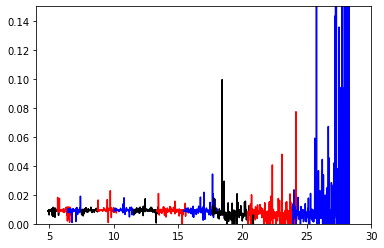

In [24]:
# Make plot
for i in range(0, 12):
    plt.plot(globals()['wavelength_' + chan_type2[i]], globals()['flux_' + chan_type2[i]], '-', color = color_list[i])

plt.xlim(4,30)
plt.ylim(0,0.15)

#### Make figures from summing up the flux in each channel of the 3D cube.

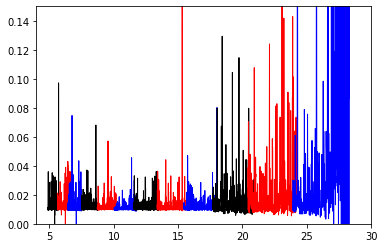

In [25]:
# Make figure and keep track of mediam value in each band
median_s3d = [0.0] * 12

for j in range(0, 12):
    image3, header3 = fits.getdata('spec3_results_' + chan_type1[j] + '_s3d.fits', header = True)
    
    num_x3 = header3["NAXIS2"]
    num_y3 = header3["NAXIS1"]
    num_chan3 = header3["NAXIS3"]
    start_wavelength3 = header3["CRVAL3"]
    step_wavelength3 = header3["CDELT3"]
    pix_size3 = header3["CDELT1"]
    
    a3 = [0.0] * num_chan3
    for i in range(0, num_chan3):
        for m in range(0, num_x3):
            for n in range(0, num_y3):
                a3[i] = image3[i, m, n] + a3[i]

    d3 = [0.0] * num_chan3
    d3[0] = start_wavelength3
    for i in range(1, num_chan3):
        d3[i] = d3[i-1] + step_wavelength3
        
    for i in range(0, num_chan3):
        a3[i] = (a3[i] * (pix_size3 * 3600) * (pix_size3 * 3600) * (10**6)) / (4.25 * 10**10)
    
    median_s3d[j]=np.median(a3)
    
    plt.plot(d3, a3, '-', color = color_list[j], lw = 1) 
    plt.xlim(4, 30)
    plt.ylim(0, 0.15)

#### Define Pass/Fail Criteria For S3D

In [26]:
# Check median is off by less than 20% of expected flux in channel/band 1a though 3c
for i in range(0, 8):
    if (100 * ((median_s3d[i]) - (0.01)) / (0.01)) < 20:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')
    else:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': fail' + ',' + np.str(np.round(a)) + '%')

2021-10-29 22:09:37,104 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_2053273/1722630998.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')



1a: pass,9.0%
1b: pass,8.0%
1c: pass,4.0%
2a: pass,7.0%
2b: pass,6.0%
2c: pass,3.0%
3a: pass,9.0%
3b: pass,8.0%


In [27]:
# Check median is off by less than 160% of expected flux in channel/band 4a though 4c
for i in range(9, 12):
    if (100 * ((median_s3d[i]) - (0.01)) / (0.01)) < 160:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')
    else:
        a = (100 * ((median_s3d[i]) - (0.01)) / (0.01))
        print(chan_type2[i] + ': fail' + ',' + np.str(np.round(a)) + '%')

2021-10-29 22:09:37,115 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_2053273/2569092362.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(chan_type2[i] + ': pass' + ',' + np.str(np.round(a)) + '%')



4a: pass,17.0%
4b: pass,37.0%
4c: pass,93.0%


#### Summary

We plot below the pass/fail criteria. In Channel/Band 1a through 3c, the criteria is that the expected median output after Spec 3 step of the pipeline is within 20% of the 0.01 Jy flat flux that was input. The output from the pipeline ranges from 9%-16% from the expected flux.

The flux output from channel 4a through 4c is off by a factor ranging from 36% to 153% off from the input flux. Therefore the set the pass/fail criterial in channel 4 such that the output should be within 160% from the input. Both the data made by mirisim and then processed by the pipeline lead to such a high discrepancy in this particular channel. MIRISim simulations in Channel 4 do not represent the data we expect to get in flight.

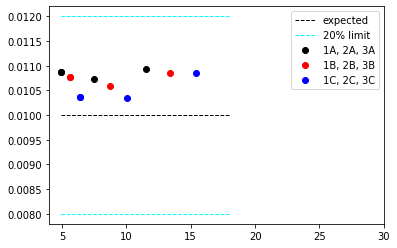

In [28]:
# Band 1A through 3C
x_limit = [4.89, 18.04]
y_limit = [0.01, 0.01]

#Set 20% Pass/Fail Criteria
y_20_upper = [0.01 + (0.01 * (0.2)), 0.01 + (0.01 * (0.2))]
y_20_lower = [0.01 - (0.01 * (0.2)), 0.01 - (0.01 * (0.2))]

plt.plot(x_limit, y_limit, '--', color='black', lw=1, label = 'expected')
plt.plot(x_limit, y_20_upper, '--', color='cyan', lw=1, label = '20% limit')
plt.plot(x_limit, y_20_lower, '--', color='cyan', lw=1,)
plt.plot(globals()['wavelength_' + chan_type2[0]][0], (median_s3d[0]), 'o', color = color_list[0], label = '1A, 2A, 3A')
plt.plot(globals()['wavelength_' + chan_type2[1]][0], (median_s3d[1]), 'o', color = color_list[1], label = '1B, 2B, 3B')
plt.plot(globals()['wavelength_' + chan_type2[2]][0], (median_s3d[2]), 'o', color = color_list[2], label = '1C, 2C, 3C')

for i in range(0, 9):
    plt.plot(globals()['wavelength_' + chan_type2[i]][0], (median_s3d[i]), 'o', color = color_list[i])

plt.xlim(4, 30)
plt.legend()

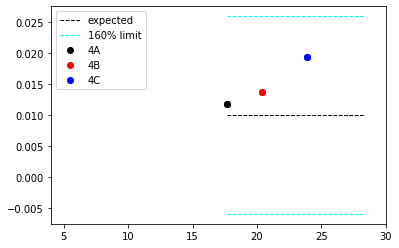

In [29]:
# Band 4A through 4C
x_limit = [17.66, 28.31]
y_limit = [0.01, 0.01]

#Set 160% Pass/Fail Criteria
y_160_upper = [0.01 + (0.01 * (1.6)), 0.01 + (0.01 * (1.6))]
y_160_lower = [0.01 - (0.01 * (1.6)), 0.01 - (0.01 * (1.6))]

plt.plot(x_limit, y_limit, '--', color='black', lw=1, label = 'expected')
plt.plot(x_limit, y_160_upper, '--', color='cyan', lw=1, label = '160% limit')
plt.plot(x_limit, y_160_lower, '--', color='cyan', lw=1)
plt.plot(globals()['wavelength_' + chan_type2[9]][0], (median_s3d[9]), 'o', color = color_list[9], label = '4A')
plt.plot(globals()['wavelength_' + chan_type2[10]][0], (median_s3d[10]), 'o', color = color_list[10], label = '4B')
plt.plot(globals()['wavelength_' + chan_type2[11]][0], (median_s3d[11]), 'o', color = color_list[11], label = '4C')

for i in range(9, 12):
    plt.plot(globals()['wavelength_' + chan_type2[i]][0], (median_s3d[i]), 'o', color = color_list[i])
    
plt.xlim(4, 30)
plt.legend()